# **Deployment of a Stock Volatility Forecasting System using GARCH Model, FastAPI, and Web Interface**

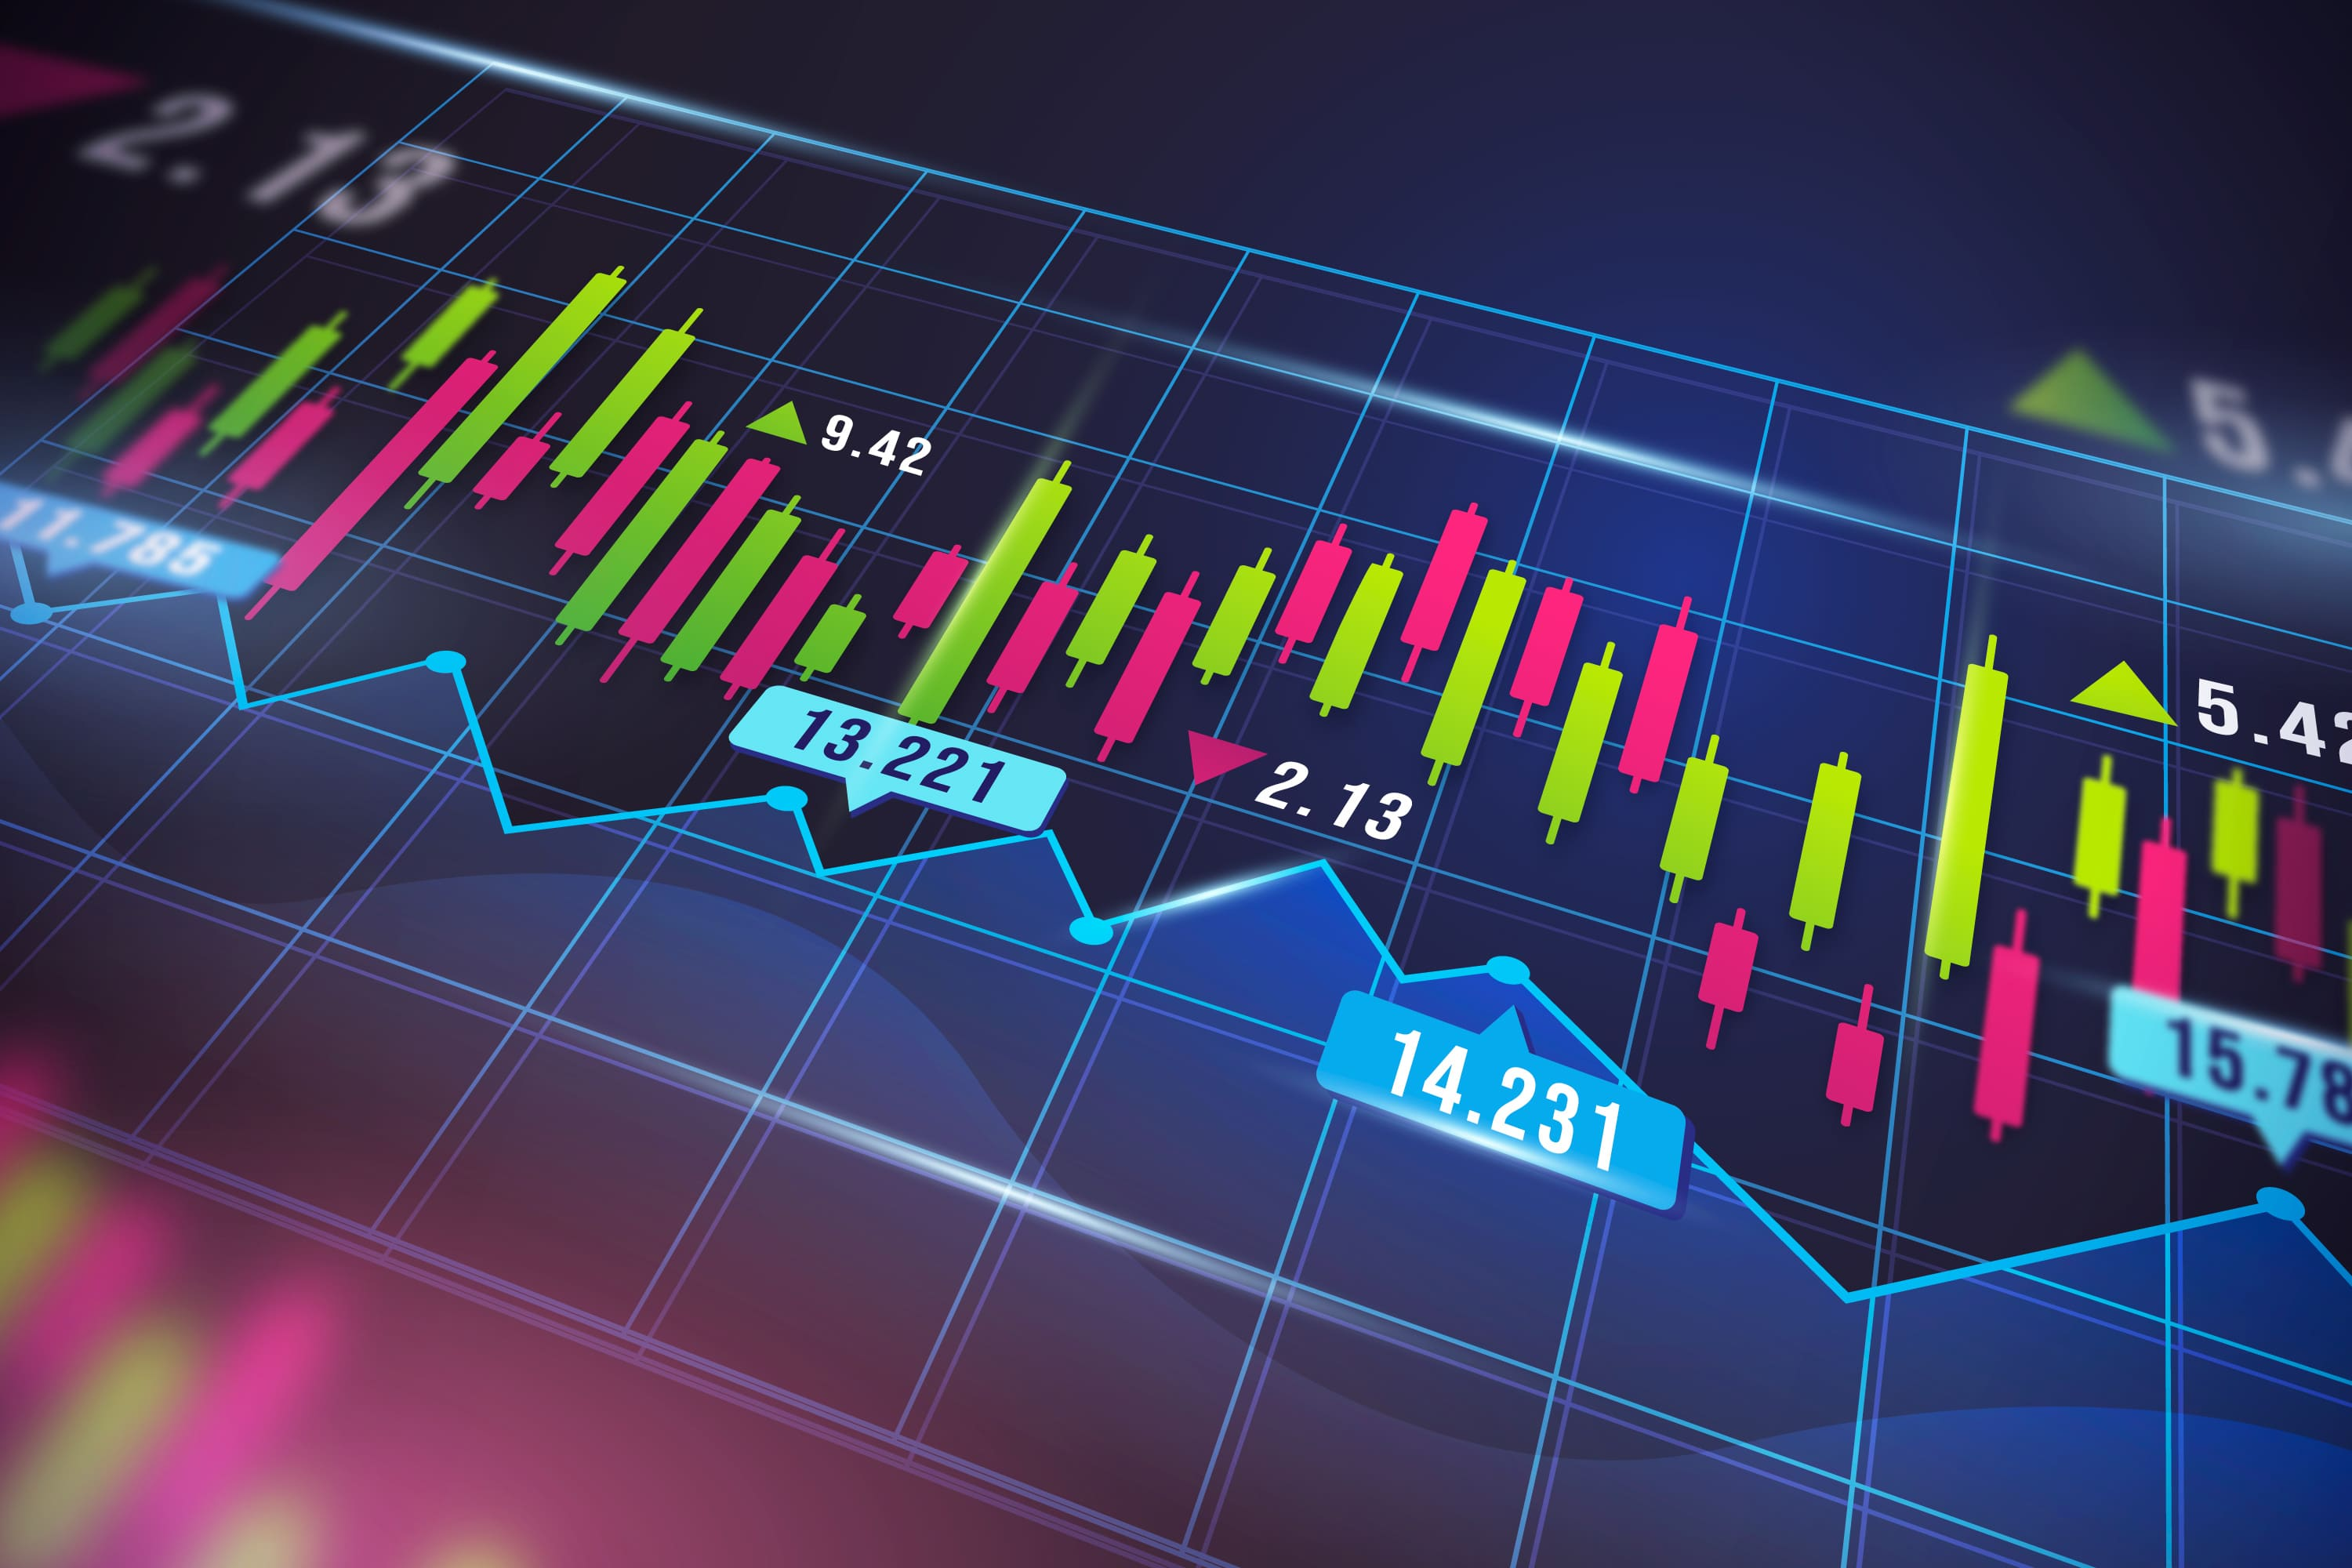

---





This project demonstrates the application of machine learning and API development techniques to create a practical tool for financial analysis and decision-making. In this project, we will utilize a GARCH (Generalized AutoRegressive Conditional Heteroskedasticity) model for stock volatility prediction, then we will develope a stock volatility prediction API using the model. This API will allow users to:

1. **Train an ML model** for a specific stock ticker, using either the latest data from Alpha Vantage or historical data stored in a SQLite database.
2. **Obtain volatility predictions** for a trained model, specifying the desired prediction horizon (number of days).

---

**Technical Details:**

*   **Data Acquisition and Storage:** The project utilizes the Alpha Vantage API to retrieve daily stock data and stores it in a SQLite database for efficient management.
*   **Model Training:** The GARCH model is employed to capture the volatility patterns in the stock data.
*   **API Development:** FastAPI is used to create a RESTful API that exposes endpoints for model training and prediction. Pydantic is used for data validation and ensuring the correctness of request parameters.
*   **Model Persistence:** Trained models are saved to disk using joblib, allowing for reuse without retraining.
*   **Deployment with ngrok:** The API is deployed using ngrok, which creates a public URL for accessing the application hosted on your Google Colab instance.
*   **Interactive Documentation:** Swagger UI or ReDoc is automatically generated by FastAPI, providing users with interactive documentation to understand and interact with the API.
*   **Web Application Development:** A web app is developed using **Plotly Dash** to provide an interactive and user-friendly interface that enables real-time use of the prediction system without requiring users to understand the underlying code.

---

**Benefits and Use Cases:**

*   **Volatility Forecasting:** The API provides a tool for predicting the volatility of a stock, which is valuable information for investors and traders in making informed decisions.
*   **Risk Management:** Volatility predictions can be used to assess the risk associated with a particular stock and to develop risk mitigation strategies.
*   **Automated Trading:** The API can be integrated into automated trading systems to trigger actions based on volatility forecasts.
*   **Research and Analysis:** Researchers and analysts can utilize the API to study stock market volatility and develop trading algorithms.

---

**PS.: This project was carried out using Google Colab.**

In [ ]:
#Install the neccessary packages

!pip install fastapi
!pip install uvicorn
!pip install pydantic
!pip install pypi-json
!pip install pyngrok
!pip install nest-asyncio
!pip install pydantic-settings
!pip install arch
!pip install python-dotenv

In [ ]:
import pandas as pd
import requests
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display, HTML
import plotly.express as px
from sklearn.model_selection import train_test_split
import os

%load_ext autoreload
%load_ext sql
%autoreload 2

import sqlite3

from glob import glob

import joblib

from arch.univariate.base import ARCHModelResult
import matplotlib.pyplot as plt

We are going to set up a convenient and secure way to manage and access confidential information (this includes our API key and ngrok token) within our stock volatility forecasting system. We will achieve this by storing these values in a separate `.env` file, thereby avoiding hardcoding them directly into our code and potentially exposing them publicly.

* You can get your ngrok authoken [here](https://dashboard.ngrok.com/get-started/your-authtoken?__hstc=19063847.75439bbbb84313a0cbcedd106694e1c5.1733356800250.1733356800251.1733356800252.1&__hssc=19063847.1.1733356800253&__hsfp=2637229211) after you have created an account with ngrok.

* You can get your **free** Alpha Vantage API Key [here](https://www.alphavantage.co/support/#api-key).

In [ ]:
# Create the .env file
# Define the file path
env_file_path = os.path.join(os.getcwd(), ".env")  # Create in current directory

# Enter your ngrok token and Alpha Vantage API key within the quotes below
env_vars = {
    "NGROK_TOKEN": "ENTER NGROK AUTHOTOKEN HERE",
    "ALPHA_API_KEY": "ENTER API KEY HERE",
    "DB_NAME": "stocks.sqlite",
    "MODEL_DIRECTORY": "models",
}

# Write the variables to the .env file
with open(env_file_path, "w") as f:
    for key, value in env_vars.items():
        f.write(f"{key}={value}\n")

print(f".env file created at: {env_file_path}")

.env file created at: /content/.env


In [ ]:
# Create the 'models' directory to store the trained models in the forecasting system
os.makedirs(settings.model_directory, exist_ok=True)

We are going to create a `Settings` class that uses Pydantic's BaseSettings to manage application settings, loading configuration variables (like API keys and database names) from environment variables.

In [ ]:
from pydantic_settings import BaseSettings


def get_db_path(db_name: str = "stocks.sqlite") -> str:
    """Constructs the full path to the SQLite database file."""

    # Get the current working directory
    base_dir = os.getcwd()
    # Join the base directory and database name to create the full path
    db_path = os.path.join(base_dir, db_name)
    return db_path

class Settings(BaseSettings):
    ngrok_token: str
    alpha_api_key: str
    db_name: str
    model_directory: str

    class Config:
        env_file = ".env"


# Create instance of `Settings` class
settings = Settings()

In [ ]:
# Print the database name from the settings
print(settings.db_name)

stocks.sqlite


## **Getting Started With Alpha Vantage API**

In [ ]:
# Create our URL to fetch daily time series data for Tesla stock from the Alpha Vantage API
ticker = 'TSLA' #Tesla Stock
url = (
    "https://www.alphavantage.co/query?"
    "function=TIME_SERIES_DAILY&"
    f"symbol={ticker}&"
    f"apikey={settings.alpha_api_key}"
)

display(HTML(f'<a href="{url}">{url}</a>'))

In [ ]:
response = requests.get(url=url)

# Get the response status code
response_code = response.status_code

response_code

200

In [ ]:
# Print out the response from the API request
response_text = response.text

print(response_text)

{
    "Meta Data": {
        "1. Information": "Daily Prices (open, high, low, close) and Volumes",
        "2. Symbol": "TSLA",
        "3. Last Refreshed": "2025-05-16",
        "4. Output Size": "Compact",
        "5. Time Zone": "US/Eastern"
    },
    "Time Series (Daily)": {
        "2025-05-16": {
            "1. open": "346.2400",
            "2. high": "351.6200",
            "3. low": "342.3300",
            "4. close": "349.9800",
            "5. volume": "95895665"
        },
        "2025-05-15": {
            "1. open": "340.3400",
            "2. high": "346.1393",
            "3. low": "334.7153",
            "4. close": "342.8200",
            "5. volume": "97882596"
        },
        "2025-05-14": {
            "1. open": "342.5000",
            "2. high": "350.0000",
            "3. low": "337.0000",
            "4. close": "347.6800",
            "5. volume": "136997264"
        },
        "2025-05-13": {
            "1. open": "320.0000",
            "2. high": "3

In [ ]:
# Convert the response, which is in text format, to a structured format (JSON)
response_data = response.json()
response_data.keys()

dict_keys(['Meta Data', 'Time Series (Daily)'])

In [ ]:
# Extract 'Time Series (Daily)' value from 'response_data'
stock_data = response_data["Time Series (Daily)"]

# Extract data for one of the days in 'stock_data'
print(stock_data.keys())

dict_keys(['2025-05-16', '2025-05-15', '2025-05-14', '2025-05-13', '2025-05-12', '2025-05-09', '2025-05-08', '2025-05-07', '2025-05-06', '2025-05-05', '2025-05-02', '2025-05-01', '2025-04-30', '2025-04-29', '2025-04-28', '2025-04-25', '2025-04-24', '2025-04-23', '2025-04-22', '2025-04-21', '2025-04-17', '2025-04-16', '2025-04-15', '2025-04-14', '2025-04-11', '2025-04-10', '2025-04-09', '2025-04-08', '2025-04-07', '2025-04-04', '2025-04-03', '2025-04-02', '2025-04-01', '2025-03-31', '2025-03-28', '2025-03-27', '2025-03-26', '2025-03-25', '2025-03-24', '2025-03-21', '2025-03-20', '2025-03-19', '2025-03-18', '2025-03-17', '2025-03-14', '2025-03-13', '2025-03-12', '2025-03-11', '2025-03-10', '2025-03-07', '2025-03-06', '2025-03-05', '2025-03-04', '2025-03-03', '2025-02-28', '2025-02-27', '2025-02-26', '2025-02-25', '2025-02-24', '2025-02-21', '2025-02-20', '2025-02-19', '2025-02-18', '2025-02-14', '2025-02-13', '2025-02-12', '2025-02-11', '2025-02-10', '2025-02-07', '2025-02-06', '2025-02-

In [ ]:
# Get stock data for '2025-04-30'
stock_data['2025-04-30']

{'1. open': '279.9000',
 '2. high': '284.4500',
 '3. low': '270.7800',
 '4. close': '282.1600',
 '5. volume': '128961057'}

In [ ]:
# Load the stock data for TSLA into a DataFrame
df_tesla = pd.DataFrame.from_dict(stock_data,orient='index',dtype=float)

print("df_tesla shape:", df_tesla.shape)
print()
print(df_tesla.info())
df_tesla.head(10)

df_tesla shape: (100, 5)

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 2025-05-16 to 2024-12-20
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   1. open    100 non-null    float64
 1   2. high    100 non-null    float64
 2   3. low     100 non-null    float64
 3   4. close   100 non-null    float64
 4   5. volume  100 non-null    float64
dtypes: float64(5)
memory usage: 4.7+ KB
None


1. open   2. high    3. low  4. close    5. volume
2025-05-16  346.240  351.6200  342.3300    349.98   95895665.0
2025-05-15  340.340  346.1393  334.7153    342.82   97882596.0
2025-05-14  342.500  350.0000  337.0000    347.68  136997264.0
2025-05-13  320.000  337.5894  316.8000    334.07  136992574.0
2025-05-12  321.990  322.2100  311.5000    318.38  112826661.0
2025-05-09  290.210  307.0400  290.0000    298.26  132387835.0
2025-05-08  279.630  289.8000  279.4100    284.82   97539448.0
2025-05-07  276.880  277.9200  271.0000    276.22   71882408.0
2025-05-06  273.105  277.7300  271.3500    275.35   76715792.0
2025-05-05  284.570  284.8490  274.4000    280.26   94618882.0

In [ ]:
# Convert the index to `DatetimeIndex`
df_tesla.index = pd.to_datetime(df_tesla.index)

# Name index as "date"
df_tesla.index.name = 'date'

print(df_tesla.info())
df_tesla.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2025-05-16 to 2024-12-20
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   1. open    100 non-null    float64
 1   2. high    100 non-null    float64
 2   3. low     100 non-null    float64
 3   4. close   100 non-null    float64
 4   5. volume  100 non-null    float64
dtypes: float64(5)
memory usage: 4.7 KB
None


1. open   2. high    3. low  4. close    5. volume
date                                                          
2025-05-16   346.24  351.6200  342.3300    349.98   95895665.0
2025-05-15   340.34  346.1393  334.7153    342.82   97882596.0
2025-05-14   342.50  350.0000  337.0000    347.68  136997264.0
2025-05-13   320.00  337.5894  316.8000    334.07  136992574.0
2025-05-12   321.99  322.2100  311.5000    318.38  112826661.0

In [ ]:
# Remove numbering from the column names
df_tesla.columns = [c.split('. ')[1] for c in df_tesla.columns]

print(df_tesla.info())
df_tesla.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2025-05-16 to 2024-12-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    100 non-null    float64
 1   high    100 non-null    float64
 2   low     100 non-null    float64
 3   close   100 non-null    float64
 4   volume  100 non-null    float64
dtypes: float64(5)
memory usage: 4.7 KB
None


open      high       low   close       volume
date                                                       
2025-05-16  346.24  351.6200  342.3300  349.98   95895665.0
2025-05-15  340.34  346.1393  334.7153  342.82   97882596.0
2025-05-14  342.50  350.0000  337.0000  347.68  136997264.0
2025-05-13  320.00  337.5894  316.8000  334.07  136992574.0
2025-05-12  321.99  322.2100  311.5000  318.38  112826661.0

This stock data table shows the daily trading information for TSLA stock over several days. Each row represents one day, starting with the date. The `open` column shows the price at which the stock first traded when the market opened. The `high` and `low` columns indicate the highest and lowest prices the stock reached during the day, showing the range of price movement. The `close` column shows the last price at which the stock traded when the market closed for the day. Finally, the `volume` column tells us how many shares of the stock were bought and sold during that day, which can indicate how active trading was.


We will include all what we have done so far into a Python class to make coding process cleaner and easier to maintain. We are going to create a class named `AlphaVantageAPI` that will help us to extract data from the Alpha Vantage API and transform the data into an approriate format.


In [ ]:
class AlphaVantageAPI:
    def __init__(self, api_key=settings.alpha_api_key):
        self.__api_key=api_key


    def get_daily_stock_data(self, ticker,output_size='full'):

        """Get daily time series of a stock from AlphaVantage API.

        Parameters
        ----------
        ticker : str
            The ticker symbol of the equity.
        output_size : str, optional
            Number of observations to retrieve. "compact" returns the
            latest 100 observations. "full" returns all observations for
            equity. By default "full".

        Returns
        -------
        pd.DataFrame
            Columns are 'open', 'high', 'low', 'close', and 'volume'.
            All are numeric.
        """
        # Create URL
        url = (
            "https://www.alphavantage.co/query?"
            "function=TIME_SERIES_DAILY&"
            f"symbol={ticker}&"
            f"outputsize={output_size}&"
            f"datatype=json&"
            f"apikey={self.__api_key}"
        )

        # Send request to API
        response = requests.get(url=url)

        # Extract JSON data from response
        response_data = response.json()

        #Include Exception for bad ticker symbol
        if 'Time Series (Daily)' not in response_data.keys():
            raise Exception (
                f'Invalid API call. Check that ticker symbol {ticker} is correct.'
            )

        # Read data into DataFrame
        stock_data = response_data["Time Series (Daily)"]
        df = pd.DataFrame.from_dict(stock_data,orient='index',dtype=float)

        # Convert index to `DatetimeIndex` named "date"
        df.index = pd.to_datetime(df.index)
        df.index.name = 'date'

        # Remove numbering from columns
        df.columns = [c.split('. ')[1] for c in df.columns]

        # Return DataFrame
        return df


In [ ]:
# Let's test the get_daily_stock_data method
# Create instance of `AlphaVantageAPI` class
av= AlphaVantageAPI()

# Define Tesla ticker symbol
ticker = "TSLA"

# Use our `av` object to get daily data
df_tsla = av.get_daily_stock_data(ticker=ticker)

print("df_tsla shape:", df_tsla.shape)
df_tsla.head()

df_tsla shape: (3745, 5)


open      high       low   close       volume
date                                                       
2025-05-16  346.24  351.6200  342.3300  349.98   95895665.0
2025-05-15  340.34  346.1393  334.7153  342.82   97882596.0
2025-05-14  342.50  350.0000  337.0000  347.68  136997264.0
2025-05-13  320.00  337.5894  316.8000  334.07  136992574.0
2025-05-12  321.99  322.2100  311.5000  318.38  112826661.0

In [ ]:
# Test the Exception
av.get_daily_stock_data(ticker="TSLLA")

Exception: Invalid API call. Check that ticker symbol TSLLA is correct.

We can see that the `get_daily_stock_data` method is working as desired. Next, we will create another class named `SQLRepository` that will assist us to load the data into an SQLite database, and to retrieve loaded data from the database. First, we are going to add the `insert_table` method to help load data into the database.

In [ ]:
class SQLRepository:
    def __init__(self, connection):
        self.connection=connection



    def insert_table(self, table_name, records, if_exists='fail'):

        """Insert DataFrame into SQLite database as table

        Parameters
        ----------
        table_name : str
        records : pd.DataFrame
        if_exists : str, optional
            How to behave if the table already exists.

            - 'fail': Raise a ValueError.
            - 'replace': Drop the table before inserting new values.
            - 'append': Insert new values to the existing table.

            Dafault: 'fail'

        Returns
        -------
        dict
            Dictionary has two keys:

            - 'transaction_successful', followed by bool
            - 'records_inserted', followed by int
        """

        n_inserted = records.to_sql(
                name = table_name,
                con = self.connection,
                if_exists = if_exists
        )
        return {'transaction_successful':True,
               'records_inserted':n_inserted
               }


In [ ]:
# Let's test the insert_data method
# Connect to our stocks.sqlite database
connection = sqlite3.connect(settings.db_name)

# Create instance of class
repo = SQLRepository(connection=connection)

# Insert TSLA stock data into the database
response = repo.insert_table(table_name="TSLA", records=df_tsla, if_exists="replace")
response

{'transaction_successful': True, 'records_inserted': 3745}

In [ ]:
# Let's check that the TSLA table has been inserted
query = '''
SELECT name
FROM sqlite_master
WHERE type='table';
'''
pd.read_sql(sql=query, con=connection)

name
0  TSLA

In [ ]:
# Get the inserted TSLA data (first ten rows only)
query = '''
SELECT *
FROM "TSLA"
LIMIT 10;
'''
pd.read_sql(sql=query, con=connection)

date     open      high       low   close       volume
0  2025-05-16 00:00:00  346.240  351.6200  342.3300  349.98   95895665.0
1  2025-05-15 00:00:00  340.340  346.1393  334.7153  342.82   97882596.0
2  2025-05-14 00:00:00  342.500  350.0000  337.0000  347.68  136997264.0
3  2025-05-13 00:00:00  320.000  337.5894  316.8000  334.07  136992574.0
4  2025-05-12 00:00:00  321.990  322.2100  311.5000  318.38  112826661.0
5  2025-05-09 00:00:00  290.210  307.0400  290.0000  298.26  132387835.0
6  2025-05-08 00:00:00  279.630  289.8000  279.4100  284.82   97539448.0
7  2025-05-07 00:00:00  276.880  277.9200  271.0000  276.22   71882408.0
8  2025-05-06 00:00:00  273.105  277.7300  271.3500  275.35   76715792.0
9  2025-05-05 00:00:00  284.570  284.8490  274.4000  280.26   94618882.0

Next, we are going to add the `read_table` method to enable us to access data from the database.

In [ ]:
class SQLRepository:
    def __init__(self, connection):
        self.connection=connection



    def insert_table(self, table_name, records, if_exists='fail'):

        """Insert DataFrame into SQLite database as table

        Parameters
        ----------
        table_name : str
        records : pd.DataFrame
        if_exists : str, optional
            How to behave if the table already exists.

            - 'fail': Raise a ValueError.
            - 'replace': Drop the table before inserting new values.
            - 'append': Insert new values to the existing table.

            Dafault: 'fail'

        Returns
        -------
        dict
            Dictionary has two keys:

            - 'transaction_successful', followed by bool
            - 'records_inserted', followed by int
        """

        n_inserted = records.to_sql(
                name = table_name,
                con = self.connection,
                if_exists = if_exists
        )
        return {'transaction_successful':True,
               'records_inserted':n_inserted
               }

    def read_table(self, table_name, limit = None):

        """Read table from database.

        Parameters
        ----------
        table_name : str
            Name of table in SQLite database.
        limit : int, None, optional
            Number of most recent records to retrieve. If `None`, all
            records are retrieved. By default, `None`.

        Returns
        -------
        pd.DataFrame
            Index is DatetimeIndex "date". Columns are 'open', 'high',
            'low', 'close', and 'volume'. All columns are numeric.
        """
        # Create SQL query (with optional limit)
        if limit:
            sql = f"SELECT * FROM '{table_name}' LIMIT {limit}"
        else:
            sql = f"SELECT * FROM '{table_name}'"


        # Retrieve data, read into DataFrame
        df = pd.read_sql(sql=sql, con=self.connection,
                        parse_dates=['date'], index_col='date')

        # Return DataFrame
        return df

In [ ]:
# Create instance of class
repo = SQLRepository(connection=connection)
df_tsla = repo.read_table(table_name="TSLA", limit=None)

print("df_tsla shape:", df_tsla.shape)
print()
print(df_tsla.info())
df_tsla.head()

df_tsla shape: (3745, 5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3745 entries, 2025-05-16 to 2010-06-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3745 non-null   float64
 1   high    3745 non-null   float64
 2   low     3745 non-null   float64
 3   close   3745 non-null   float64
 4   volume  3745 non-null   float64
dtypes: float64(5)
memory usage: 175.5 KB
None


open      high       low   close       volume
date                                                       
2025-05-16  346.24  351.6200  342.3300  349.98   95895665.0
2025-05-15  340.34  346.1393  334.7153  342.82   97882596.0
2025-05-14  342.50  350.0000  337.0000  347.68  136997264.0
2025-05-13  320.00  337.5894  316.8000  334.07  136992574.0
2025-05-12  321.99  322.2100  311.5000  318.38  112826661.0

## **Exploratory Data Analysis**



We are going to analyse two stocks: Apple Inc (AAPL) and Microsoft Corp (MSFT). But we need to first extract the data for both stocks and store the data in our database.

In [ ]:
# Get the AAPL stock data
df_aapl = av.get_daily_stock_data(ticker='AAPL')

# Insert the AAPL data into the database
repo.insert_table(table_name='AAPL', records=df_aapl, if_exists="replace")

# Read the AAPL data from database (to confirm that it has been successfully added)
repo.read_table(table_name="AAPL", limit=None)

open      high       low   close      volume
date                                                      
2025-05-16  212.36  212.5700  209.7700  211.26  54737850.0
2025-05-15  210.95  212.9600  209.5400  211.45  45029473.0
2025-05-14  212.43  213.9400  210.5801  212.33  49325825.0
2025-05-13  210.43  213.4000  209.0000  212.93  51909332.0
2025-05-12  210.97  211.2679  206.7500  210.79  63775814.0
...            ...       ...       ...     ...         ...
1999-11-05   84.62   88.3700   84.0000   88.31   3721500.0
1999-11-04   82.06   85.3700   80.6200   83.62   3384700.0
1999-11-03   81.62   83.2500   81.0000   81.50   2932700.0
1999-11-02   78.00   81.6900   77.3100   80.25   3564600.0
1999-11-01   80.00   80.6900   77.3700   77.62   2487300.0

[6425 rows x 5 columns]

In [ ]:
# Get the MSFT stock data
df_msft = av.get_daily_stock_data(ticker='MSFT')

# Insert the MSFT data into the database
repo.insert_table(table_name='MSFT', records=df_msft, if_exists="replace")

# Read the MSFT data from database (to confirm that it has been successfully added)
repo.read_table(table_name="MSFT", limit=None)

open      high       low   close      volume
date                                                       
2025-05-16  452.050  454.3600  448.7300  454.27  23849781.0
2025-05-15  450.765  456.1900  450.4301  453.13  21992323.0
2025-05-14  448.140  453.9000  448.1400  452.94  19902796.0
2025-05-13  447.780  450.6733  445.3600  449.14  23618819.0
2025-05-12  445.940  449.3700  439.7800  449.26  22821935.0
...             ...       ...       ...     ...         ...
1999-11-05   91.810   92.8700   90.5000   91.56  35083700.0
1999-11-04   92.310   92.7500   90.3100   91.75  27119700.0
1999-11-03   92.940   93.5000   91.5000   92.00  22258500.0
1999-11-02   92.750   94.5000   91.9400   92.56  23174500.0
1999-11-01   93.250   94.1900   92.1200   92.37  26630600.0

[6425 rows x 5 columns]

In [ ]:
# Let's visualize how the price of AAPL changed over the years
fig = px.line(
    df_aapl,
    x=df_aapl.index,
    y='close',
    title='AAPL Closing Price Over Time',
    labels={'close': 'Closing Price', 'index': 'Date'},
    line_shape='linear'
)

fig.show()

Here are some key observations that we can derive from the plot above:

* AAPL remained relatively low and volatile in the early 2000s. Growth accelerated around 2004–2007, coinciding with the rise of the iPod and the shift toward consumer electronics.

* AAPL experienced a sharp decline in 2008, reflecting the global financial crisis.

* AAPL saw exponential growth from 2009 onward, driven by the iPhone 3GS, iPhone 4, and iPad launches. The introduction of the App Store and strong Mac sales also contributed to this surge.
AAPL peaked around 2012, reflecting the dominance of the iPhone.

* AAPL saw a sharp drop in early 2020 during the COVID-19 pandemic. It quickly rebounded as tech stocks surged due to increased demand for digital services and devices.
2022–2024 Volatility



In [ ]:
# Let's visualize how the price of MSFT changed over the years
fig = px.line(
    df_msft,
    x=df_msft.index,
    y='close',
    title='MSFT Closing Price Over Time',
    labels={'close': 'Closing Price', 'index': 'Date'},
    line_shape='linear'
)

fig.show()


Here are some key observations that we can derive from the plot above:

* MSFT experienced a sharp decline in the early 2000s, reflecting the burst of **the dot-com bubble**. The stock stagnated as Microsoft struggled to grow beyond Windows and Office.

* From 2003 to 2013, Microsoft’s stock price remained relatively flat, growing slowly.
The company faced competition from Apple and Google in mobile computing and cloud services.

* The stock began rising rapidly in 2013, coinciding with Satya Nadella becoming CEO in 2014. Microsoft shifted focus to cloud computing (Azure), AI, and enterprise services, driving strong revenue growth.

* During the COVID-19 pandemic, MSFT saw a huge surge as demand for cloud computing, remote work software (Teams, Office 365), and gaming (Xbox) increased.

* In 2022, inflation concerns and rising interest rates led to a slowdown in tech stocks, causing temporary declines.

* In 2023 and 2024, AI investments (OpenAI partnership, Azure AI services) helped drive Microsoft’s stock to all-time highs.

In [ ]:
# Plot the closing price of both AAPL and MSFT in one plot
# Combine the data into one DataFrame with a new column to distinguish the stocks
df_aapl_copy = df_aapl.copy()
df_aapl_copy['Stock'] = 'AAPL'

df_msft_copy = df_msft.copy()
df_msft_copy['Stock'] = 'MSFT'

# Concatenate both DataFrames
df_combined = pd.concat([df_aapl_copy, df_msft_copy])

# Plot
fig = px.line(
    df_combined,
    x=df_combined.index,
    y='close',
    color='Stock',
    title='AAPL vs MSFT Closing Prices',
    labels={'close': 'Closing Price', 'index': 'Date'}
)

fig.show()


Looking at this plot, we might conclude that **Apple inc** is a "better" stock than **Microsoft Corp** because its price is higher. But price is just one factor that an investor must consider when creating an investment strategy. What is definitely true is that it's hard to do a head-to-head comparison of these two stocks because there's such a large price difference. One way in which investors compare stocks is by looking at their returns instead. **Returns** refer to the profit or loss made on an investment over a specific period, expressed either as a raw amount or as a percentage of the initial value. So let's calculate the daily returns (in percentage) for our two stocks.

In [ ]:
# Sort DataFrame ascending by date
df_aapl.sort_index(ascending=True, inplace=True)

# Create "return" column
df_aapl['return']=df_aapl['close'].pct_change()*100

# Drop rows with NaN values in the 'return' column
df_aapl.dropna(subset=['return'], inplace=True)

print("df_aapl shape:", df_aapl.shape)
print()
print(df_aapl.info())
df_aapl.head()

df_aapl shape: (6424, 6)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6424 entries, 1999-11-02 to 2025-05-16
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6424 non-null   float64
 1   high    6424 non-null   float64
 2   low     6424 non-null   float64
 3   close   6424 non-null   float64
 4   volume  6424 non-null   float64
 5   return  6424 non-null   float64
dtypes: float64(6)
memory usage: 351.3 KB
None


open   high    low  close     volume    return
date                                                       
1999-11-02  78.00  81.69  77.31  80.25  3564600.0  3.388302
1999-11-03  81.62  83.25  81.00  81.50  2932700.0  1.557632
1999-11-04  82.06  85.37  80.62  83.62  3384700.0  2.601227
1999-11-05  84.62  88.37  84.00  88.31  3721500.0  5.608706
1999-11-08  87.75  97.73  86.75  96.37  8490400.0  9.126939

In [ ]:
# Sort DataFrame ascending by date
df_msft.sort_index(ascending=True, inplace=True)

# Create "return" column
df_msft['return']=df_msft['close'].pct_change()*100

# Drop rows with NaN values in the 'return' column
df_msft.dropna(subset=['return'], inplace=True)

print("df_msft shape:", df_msft.shape)
print()
print(df_msft.info())
df_msft.head()

df_msft shape: (6424, 6)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6424 entries, 1999-11-02 to 2025-05-16
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6424 non-null   float64
 1   high    6424 non-null   float64
 2   low     6424 non-null   float64
 3   close   6424 non-null   float64
 4   volume  6424 non-null   float64
 5   return  6424 non-null   float64
dtypes: float64(6)
memory usage: 351.3 KB
None


open   high    low  close       volume    return
date                                                         
1999-11-02  92.75  94.50  91.94  92.56   23174500.0  0.205694
1999-11-03  92.94  93.50  91.50  92.00   22258500.0 -0.605013
1999-11-04  92.31  92.75  90.31  91.75   27119700.0 -0.271739
1999-11-05  91.81  92.87  90.50  91.56   35083700.0 -0.207084
1999-11-08  84.81  90.75  84.37  89.94  121909600.0 -1.769332

In [ ]:
# Plot the daily returns of both AAPL and MSFT in one plot
# Add a label to each DataFrame to indicate the stock
df_aapl_copy = df_aapl.copy()
df_aapl_copy['Stock'] = 'AAPL'

df_msft_copy = df_msft.copy()
df_msft_copy['Stock'] = 'MSFT'

# Combine the two DataFrames
df_combined_returns = pd.concat([df_aapl_copy, df_msft_copy])

# Plot using Plotly Express
fig = px.line(
    df_combined_returns,
    x=df_combined_returns.index,
    y='return',
    color='Stock',
    title='Daily Returns: AAPL vs MSFT',
    labels={'return': 'Daily Return', 'index': 'Date'}
)

fig.show()


We can see that the returns for **Apple Inc** have a wider spread or volatilty. We see big gains and big losses, meaning it may offer larger potential gains but also greater potential losses — making it more suitable for investors with a higher risk tolerance who are seeking aggressive growth. In contrast, the spread for **Microsoft Corp** is narrower, meaning that the price doesn't fluctuate as much. This can be attractive to conservative investors who prioritize steady returns and lower risk. Let's cofnfirm this with numbers by calculating the daily volatility for each stock.

In [ ]:
aapl_daily_volatility = df_aapl['return'].std()
msft_daily_volatility = df_msft['return'].std()

print("Apple Inc Daily Volatility:", aapl_daily_volatility)
print("Microsoft Corp Daily Volatility:", msft_daily_volatility)

Apple Inc Daily Volatility: 2.953236730911246
Microsoft Corp Daily Volatility: 2.005233114756293


This shows that **Apple Inc** is more volatile than **Microsoft Corp**, as we saw in our time series plot, where **Apple Inc** returns have a much wider spread. While daily volatility is useful, investors are also interested in volatility over other time periods — like annual volatility. Keep in mind that a year isn't 365 days for a stock market. After excluding weekends and holidays, most markets have only 252 trading days.

In [ ]:
aapl_annual_volatility = aapl_daily_volatility*np.sqrt(252)
msft_annual_volatility = msft_daily_volatility*np.sqrt(252)

print("Apple Inc Annual Volatility:", aapl_annual_volatility)
print("Microsoft Corp Annual Volatility:", msft_annual_volatility)

Apple Inc Annual Volatility: 46.88117971615521
Microsoft Corp Annual Volatility: 31.83208885413957


**Apple** still has higher volatility than **Microsoft** annually. Another way we can look at volatility is by calculating it using a rolling window.

In [ ]:
# Calculate the rolling volatility of AAPL using a 30-day window
aapl_rolling_30d_volatility = df_aapl['return'].rolling(window=50).std().dropna()

print("aapl_rolling_30d_volatility shape:", aapl_rolling_30d_volatility.shape)
aapl_rolling_30d_volatility.head()

aapl_rolling_30d_volatility shape: (6375,)


date
2000-01-12    4.109816
2000-01-13    4.357600
2000-01-14    4.380742
2000-01-18    4.391107
2000-01-19    4.339636
Name: return, dtype: float64

In [ ]:
# Calculate the rolling volatility of MSFT using a 30-day window
msft_rolling_30d_volatility = df_msft['return'].rolling(window=50).std().dropna()

print("rolling_30d_volatility shape:", msft_rolling_30d_volatility.shape)
msft_rolling_30d_volatility.head()

rolling_30d_volatility shape: (6375,)


date
2000-01-12    2.370743
2000-01-13    2.381335
2000-01-14    2.436428
2000-01-18    2.455687
2000-01-19    2.684886
Name: return, dtype: float64

In [ ]:
# Plot the 30-day rolling volatility for AAPL
# Create a copy of the AAPL DataFrame
df_aapl_copy = df_aapl.copy()

# Add the 30-day rolling volatility as a new column
df_aapl_copy['30d rolling volatility'] = aapl_rolling_30d_volatility

# Reshape the DataFrame for Plotly Express
df_melted = (
    df_aapl_copy[['return', '30d rolling volatility']]
    .reset_index()
    .melt(id_vars='date', var_name='Metric', value_name='Value')
)

# Plot with Plotly Express
fig = px.line(
    df_melted,
    x='date',
    y='Value',
    color='Metric',
    title='AAPL Daily Return and 30-Day Rolling Volatility',
    labels={'index': 'Date', 'Value': 'Value'}
)

fig.show()


In [ ]:
# Plot the 30-day rolling volatility for MSFT
# Create a copy of the MSFT DataFrame
df_msft_copy = df_msft.copy()

# Add the 30-day rolling volatility as a new column
df_msft_copy['30d rolling volatility'] = msft_rolling_30d_volatility

# Reshape the DataFrame for Plotly Express
df_melted = (
    df_msft_copy[['return', '30d rolling volatility']]
    .reset_index()
    .melt(id_vars='date', var_name='Metric', value_name='Value')
)

# Plot with Plotly Express
fig = px.line(
    df_melted,
    x='date',
    y='Value',
    color='Metric',
    title='MSFT Daily Return and 30-Day Rolling Volatility',
    labels={'index': 'Date', 'Value': 'Value'}
)

fig.show()

## **Model Training**

### **GARCH (Generalized Autoregressive Conditional Heteroskedasticity) Model**

The **GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model** is a statistical tool used to model and forecast **financial volatility**, which refers to how much prices fluctuate over time. For beginners, it's important to understand that financial markets don’t have constant risk—some days are calm, others are turbulent. GARCH captures this by estimating how today’s volatility depends on past **squared returns (shocks)** and past **volatility**, making it especially useful for assets that show **volatility clustering**—periods of high volatility followed by more high volatility, and vice versa. It’s commonly used in finance to forecast future market risk, price options, or design trading strategies. Unlike simple models that assume constant variance, GARCH adapts to changing conditions, giving a more realistic picture of risk. However, it assumes returns have a mean of zero and are normally distributed, so it may need modifications or extensions (like EGARCH or GJR-GARCH) for more complex financial behavior.


In [ ]:
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df = repo.read_table(table_name=ticker, limit=n_observations + 1)

    # Sort DataFrame ascending by date
    df.sort_index(ascending=True, inplace=True)

    # Create "return" column
    df['return']=df['close'].pct_change()*100


    # Return returns
    return df['return'].dropna()

In [ ]:
#Create a series y_aapl that will be used to train our model
y_aapl = wrangle_data(ticker="AAPL", n_observations=2500)
print("y_aapl shape:", y_aapl.shape)
y_aapl.head()

y_aapl shape: (2500,)


date
2015-06-10    1.145817
2015-06-11   -0.225016
2015-06-12   -1.104285
2015-06-15   -0.196587
2015-06-16    0.535771
Name: return, dtype: float64

We read that GARCH assumes returns have a mean of zero and are normally distributed. Let's plot the distributions of AAPL and MSFT returns to check if they obey the assumption.

In [ ]:
# Plot the distribution of AAPL returns
fig = px.histogram(y_aapl, x='return', nbins=25,
                   title='Distribution of Apple Inc Daily Returns',
                   labels={'returns': 'Daily Returns'})

fig.show()

In [ ]:
#Create a series y_msft that will be used to train our model
y_msft = wrangle_data(ticker="MSFT", n_observations=2500)
print("y_msft shape:", y_msft.shape)
y_msft.head()

y_msft shape: (2500,)


date
2015-06-10    2.102957
2015-06-11   -0.364729
2015-06-12   -1.012059
2015-06-15   -1.076789
2015-06-16    0.780649
Name: return, dtype: float64

In [ ]:
# Plot the distribution of MSFT returns
fig = px.histogram(y_msft, x='return', nbins=25,
                   title='Distribution of Microsoft Daily Returns',
                   labels={'returns': 'Daily Returns'})

fig.show()

Looking at the distribution of Apple Inc and Microsoft Corp daily returns, we can infer that returns follow an almost normal distribution, centered on 0.

---

Financial return series often show a problem called **volatility clustering**, where large changes in price are followed by more large changes (of either sign), and small changes tend to follow small changes. This means that the volatility—or risk—of returns changes over time, rather than remaining constant. Traditional time series models assume constant variance and therefore fail to capture this dynamic behavior. To solve this, models like **GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** were developed to model **time-varying volatility**. Since volatility is the **variance** of returns, and variance is based on **squared deviations**, GARCH models use **squared returns** to represent shocks in the market. Moreover, squaring the returns removes the direction (positive or negative) and focuses on the **size of the change**, allowing the model to detect and learn from patterns in volatility over time. For example, if return today is +5% or -5%, both represent high volatility — squaring returns turns both into 0.0025 (i.e., 0.05²), focusing on the magnitude rather than the direction.


In [ ]:
# Square the AAPL returns
aapl_squared_returns = y_aapl**2

# Reset the index to bring 'date' into the DataFrame
aapl_squared_returns = aapl_squared_returns.reset_index()

# Rename columns for clarity
aapl_squared_returns.columns = ['date', 'squared_return']

# Plot the squared returns
fig = px.line(
    aapl_squared_returns,
    x='date',
    y='squared_return',
    labels={'date': 'Date', 'squared_return': 'Squared Return'},
    title='Squared Returns of Apple Inc'
)

fig.update_layout(width=1000, height=400)
fig.show()


In [ ]:
# Square the MSFT returns
msft_squared_returns = y_msft**2

# Reset the index to bring 'date' into the DataFrame
msft_squared_returns = msft_squared_returns.reset_index()

# Rename columns for clarity
msft_squared_returns.columns = ['date', 'squared_return']

# Plot the squared returns
fig = px.line(
    msft_squared_returns,
    x='date',
    y='squared_return',
    labels={'date': 'Date', 'squared_return': 'Squared Return'},
    title='Squared Returns of Microsoft'
)

fig.update_layout(width=1000, height=400)
fig.show()


In a GARCH(p,q) model, the parameters **p** and **q** define the structure of the model’s volatility equation.

**p (Order of the ARCH term - Autoregressive Conditional Heteroskedasticity)**

* Represents the number of lagged values of the squared residuals (or squared returns) from the mean equation that are used to model the current conditional variance.
* A GARCH model with p = 1 means that the current volatility is influenced by the squared shock (squared residual) from the previous period.
* It captures the short-run impact of shocks on volatility – how large past deviations from the mean affect current volatility.

**q (Order of the GARCH term - Generalized Autoregressive Conditional Heteroskedasticity)**

* Represents the number of lagged values of the conditional variance itself that are used to model the current conditional variance.
* A GARCH model with q = 1 means that the current volatility is influenced by the volatility from the previous period.
* It captures the persistence of volatility – how long past volatility levels influence current volatility.

---

The **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** of **squared returns** play a crucial role to help determine the potential order of the ARCH (*p*) and GARCH (*q*) components that best capture the time-varying volatility in our financial time series data.

Here's a breakdown of their roles:

**1. Detecting ARCH Effects (Volatility Clustering):**

* **ACF of Squared Returns:** If the ACF of the squared returns shows significant autocorrelations over several lags, it strongly suggests the presence of **ARCH effects** or **volatility clustering**. This means that large returns (positive or negative) tend to be followed by other large returns, and small returns tend to be followed by small returns. The persistence of these significant autocorrelations indicates how long these volatility shocks tend to linger.

**2. Suggesting the Order of the ARCH Component (p):**

* **PACF of Squared Returns:** The Partial Autocorrelation Function helps to isolate the direct impact of a specific lagged squared return on the current squared return, removing the influence of the intervening lags.
* The lag at which the PACF of the squared returns **cuts off** (becomes statistically insignificant after a certain number of lags) can provide an initial indication for the order of the ARCH component (*p*). If there's a significant spike at lag 1 and then the PACF drops sharply to insignificant values afterwards, it might suggest a *p* of 1. If there are significant spikes at lags 1 and 2, and then it cuts off, a *p* of 2 might be considered, and so on.

**3. Suggesting the Order of the GARCH Component (q):**

* **ACF of Squared Returns:** While the ACF helps detect ARCH effects, the *pattern* of the significant autocorrelations can offer clues about the GARCH component (*q*). If the ACF of the squared returns decays slowly and remains significant over many lags, it often suggests the presence of a GARCH component. This slow decay implies that past volatility levels have a persistent impact on current volatility.
* While the PACF is more directly used for suggesting *p*, the ACF, in conjunction with the PACF, helps in jointly determining *p* and *q*. If the ACF decays slowly and the PACF has a few significant spikes and then cuts off, it might suggest a GARCH(*p*, *q*) model where *q* is related to the persistent decay in the ACF.






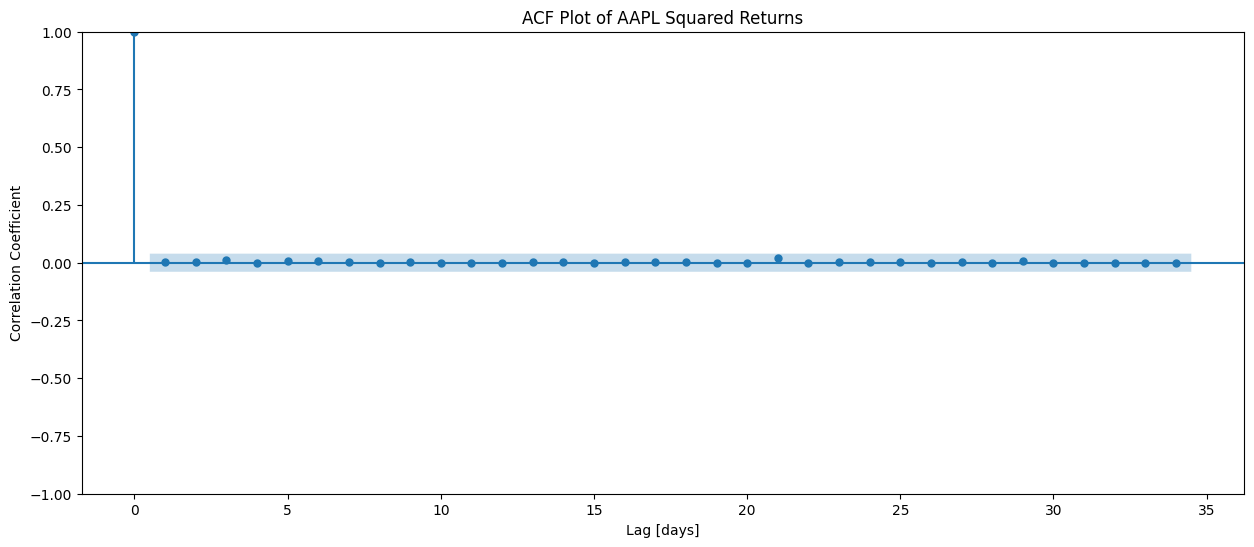

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of AAPL squared returns
plot_acf(y_aapl**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")
plt.title("ACF Plot of AAPL Squared Returns");

From the ACF plot, the lag-0 bar is always 1 because any series is perfectly correlated with itself. All other lags (1–34) have bars within the confidence band, which implies there is no significant autocorrelation in the squared returns. This could mean that the volatility (variance) in AAPL squared returns does not cluster — i.e., high-volatility periods are not strongly followed by other high-volatility periods. This is also shown by the time series plot of AAPL squared returns that we created earlier.

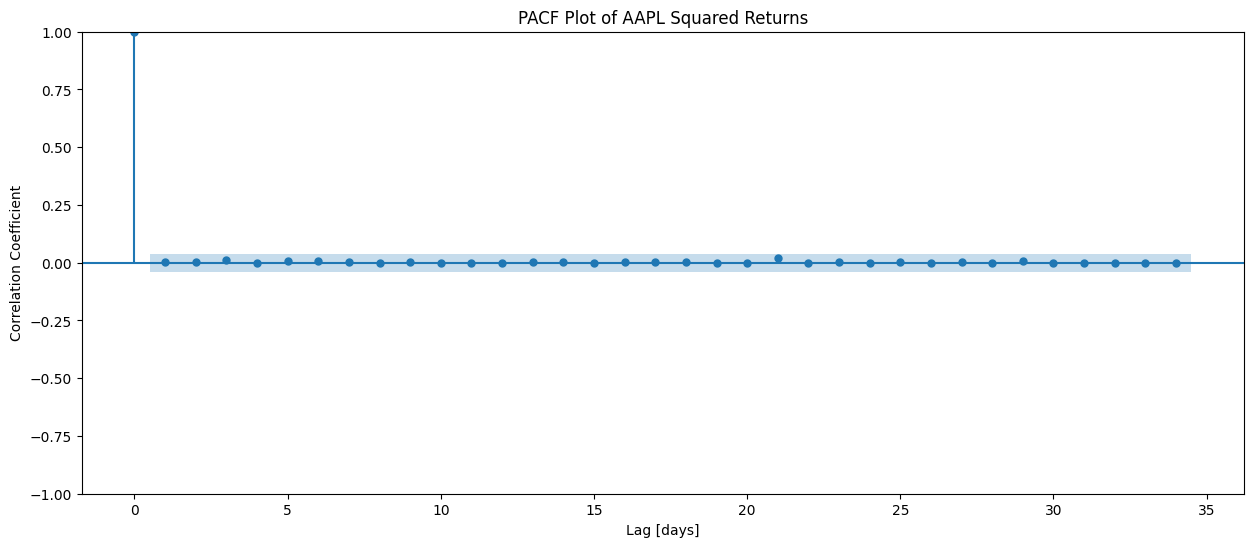

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_aapl**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")
plt.title("PACF Plot of AAPL Squared Returns");

From the PACF plot, all other lags beyond lag 0 are near zero (within the confidence band), indicating there is no statistically significant partial autocorrelation in the squared returns. This suggests that there is no significant direct relationship between the squared return at a given lag and the current squared return. Since both ACF and PACF of the squared returns show no significant spikes after lag 0, that’s an indication that a GARCH-type model might not be necessary or effective for this AAPL stock data. Most stock squared returns show volatility clustering but there are also some exceptions like we have just seen with the AAPL data. Let's take a look at the MSFT squared returns.

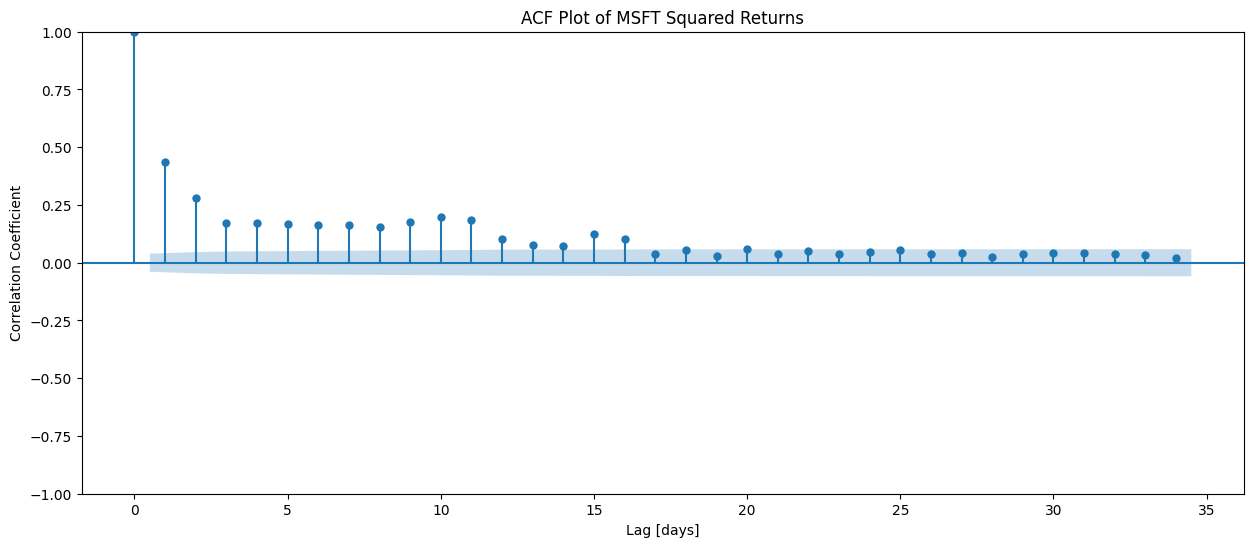

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_msft**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")
plt.title("ACF Plot of MSFT Squared Returns");

The significant autocorrelations in the ACF at lags 1 and 2, along with the gradual decay, strongly suggest the presence of ARCH effects (volatility clustering) in the MSFT squared returns. This indicates that periods of high (or low) volatility tend to be followed by similar periods.  This is also shown by the time series plot of MSFT squared returns that we created earlier.

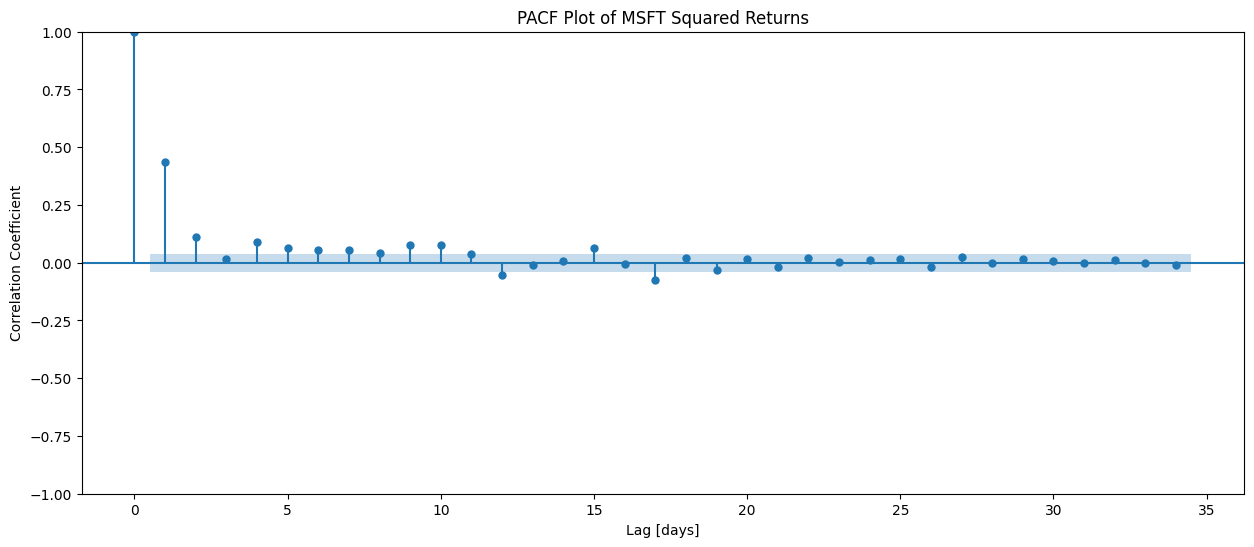

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_msft**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")
plt.title("PACF Plot of MSFT Squared Returns");

This PACF plot shows a noticeable spike at lag 1, suggesting that the time series is significantly correlated with its immediate past. We can also notice a spike at lag 2. The partial autocorrelations at higher lags appear much smaller and likely fall within the confidence intervals, indicating no additional statistically significant lags. Consequently, an **AR(1)** model may capture most of the serial dependence in the data, as there is minimal evidence of longer-range autocorrelation. This pattern is common in many financial or economic time series, where short-term memory (lag 1) dominates while higher-order lags have little effect. Generally, a **Garch(1,1)** is used for almost all time series analysis because all of its coefficients (omega, alpha and beta) are generally statistically significant.

Since both the ACF and PACF of the MSFT squared returns show noticeable spikes at lag 1 and lag 2, we are going to compare the following GARCH-type models: GARCH (1,1), GARCH(2,1), GARCH(1,2), and GARCH(2,2), then we will select the best model.

### **Data Splitting**

We are going to split our data into training and testing sets in the ratio of 80:20, without shuffling. We will not shuffle time series data before splitting it into train and test sets because it destroys the temporal order, causing the model to learn from future data and resulting in an unrealistic and overly optimistic evaluation of its predictive capabilities.

In [ ]:
# Split the MSFT data into training and testing sets
y_msft_train, y_msft_test = train_test_split(y_msft, test_size=0.2, shuffle=False)

print("y_msft_train shape:", y_msft_train.shape)
print("y_msft_test shape:", y_msft_test.shape)

y_msft_train shape: (2000,)
y_msft_test shape: (500,)


In [ ]:
# Train the GARCH(1,1) model using y_msft_train
model_11 = arch_model(y_msft_train, p=1, q=1, rescale=False).fit(disp=0)

# Show model summary
model_11.summary()

A good GARCH model is one where all the coefficients are statistically significant (p < 0.05). From the results above, the **ARCH term coefficient (alpha[1])** of 0.1974 is statistically significant (P > |t| = 2.234e-02, which is less than 0.05), suggesting that past squared returns (shocks) have a significant impact on current volatility. The **GARCH term coefficient (beta[1])** of 0.7418 is highly statistically significant (P > |t| = 1.357e-12, which is not less than 0.05), indicating a strong persistence of volatility – past volatility levels strongly influence current volatility. The **omega term (0.2176)** is not statistically significant at the 5% level (P > |t| = 7.892e-02), which could imply that the constant component of the variance equation is not reliably different from zero in this model. Overall, the significant alpha[1] and beta[1] coefficients confirm the presence of ARCH and GARCH effects in MSFT returns, suggesting that the GARCH(1,1) model is appropriate for capturing the time-varying volatility.

Let's look at the other GARCH-type models. In this case, we are going to compare the models by looking at the AIC (Akaike Information Criterion) score. The AIC score will help us to find a good fit without too much complexity. The lower the score, the better the model fits to the data.

In [ ]:
# Train the GARCH(1,2) model using y_msft_train
model_12 = arch_model(y_msft_train, p=1, q=2, rescale=False).fit(disp=0)

# Show model summary
model_12.summary()

In [ ]:
# Train the GARCH(2,1) model using y_msft_train
model_21 = arch_model(y_msft_train, p=2, q=1, rescale=False).fit(disp=0)

# Show model summary
model_21.summary()

In [ ]:
# Train the GARCH(2,2) model using y_msft_train
model_22 = arch_model(y_msft_train, p=2, q=2, rescale=False).fit(disp=0)

# Show model summary
model_22.summary()

We can see that the GARCH(1,2) model has the lowest AIC, hence we will select the model. Let's create a visual representation of our GARCH(1,2) model's performance to help us see if our GARCH model is effectively capturing periods of increased or decreased price instability.

In [ ]:
# Train the GARCH(1,2) model using y_msft_train
model = arch_model(y_msft_train, p=1, q=2, rescale=False).fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3723.95
Distribution:                  Normal   AIC:                           7457.90
Method:            Maximum Likelihood   BIC:                           7485.90
                                        No. Observations:                 2000
Date:                Sun, May 18 2025   Df Residuals:                     1999
Time:                        11:22:54   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1404  3.152e-02      4.453  8.471e-06 [7.858e-02,  0.202]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2346      0.128      1.829  6.740e-02 [-1.680e-02,  0.486]
alpha[1]       0.2167  8.572e-02      2.527  1.149e-02  [4.863e-02,  0.385]
beta[1]        0.5081      0.149      3.408  6.537e-04    [  0.216,  0.800]
beta[2]        0.2082      0.166      1.253      0.210    [ -0.117,  0.534]
===========================================================================

Covariance estimator: robust
"""

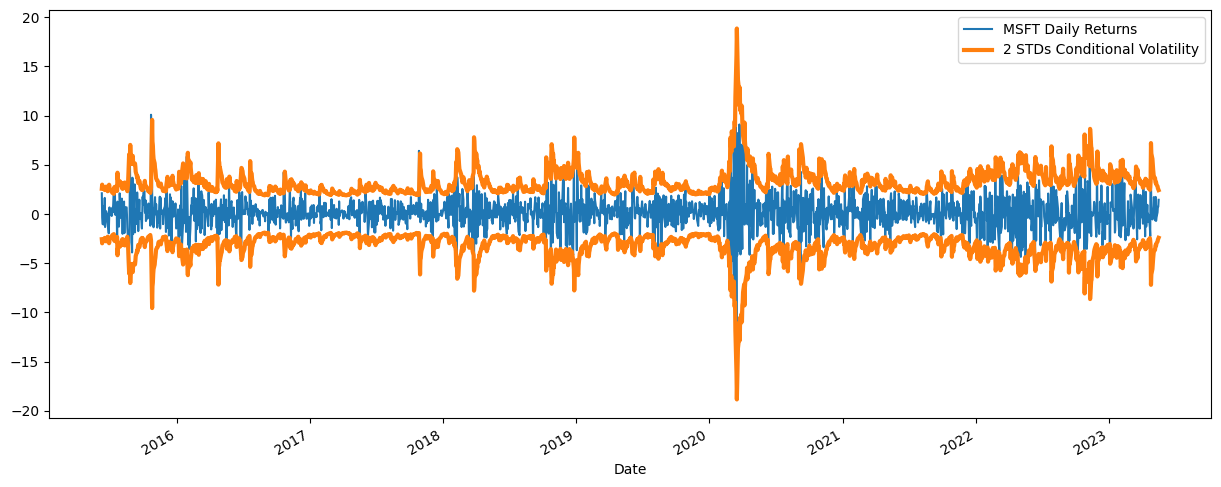

In [ ]:
# Create a time series plot with the MSFT returns and the conditional volatility for the model
fig, ax = plt.subplots(figsize=(15, 6))

# Plot daily percentage returns in `y_msft_train`
y_msft_train.plot(ax=ax, label='MSFT Daily Returns')

# Plot conditional volatility * 2 (upper bound)
(2*model.conditional_volatility).plot(ax=ax, color='C1',
                                      label='2 STDs Conditional Volatility',
                                      linewidth=3)

# Plot conditional volatility * -2 (lower bound)
(-2*model.conditional_volatility.rename('')).plot(ax=ax, color='C1',linewidth=3)

# Add axis labels
plt.xlabel('Date')


# Add legend
plt.legend();

The blue line shows the actual daily percentage changes (returns) in MSFT's price. The shaded region, outlined by the two other orange lines, represents a band of what the model predicts as the likely range of these daily price changes, specifically within two standard deviations. Think of it as the model's way of saying, 'Based on past behavior, we expect most daily returns to fall within this band.' When the blue line moves outside this band, it indicates days with larger-than-expected price swings, which can be interpreted as higher realized volatility than the model predicted.

We are also going to plot the distribution of the **standardized residuals** (the 'leftovers' or the 'unexpected' parts of the returns after our model has accounted for the volatility) of our GARCH(1,1) model to help us assess if the model has done a good job of capturing the underlying volatility dynamics in MSFT stock returns. If the model performed well, the distribution of these standardized residuals or unexpected returns will be roughly centered around zero, have a similar spread to a normal distribution, and will not have excessively skewness.

In [ ]:
# Convert standardized residuals to a DataFrame
standard_resid = pd.DataFrame({'Standardized Residuals': model.std_resid})

# Create histogram using Plotly Express
fig = px.histogram(
    standard_resid,
    x='Standardized Residuals',
    nbins=25,
    title='Distribution of Standardized Residuals',
    labels={'x': 'Standardized Residuals', 'y': 'Frequency [count]'}
)

# Show the plot
fig.show()


We can see that the distribution of the standardized residuals is centered around zero, have a similar spread to a normal distribution, and does not have excessively skewness. Hence, the GARCH(1,1) model performed well in capturing the underlying volatility dynamics in MSFT stock returns

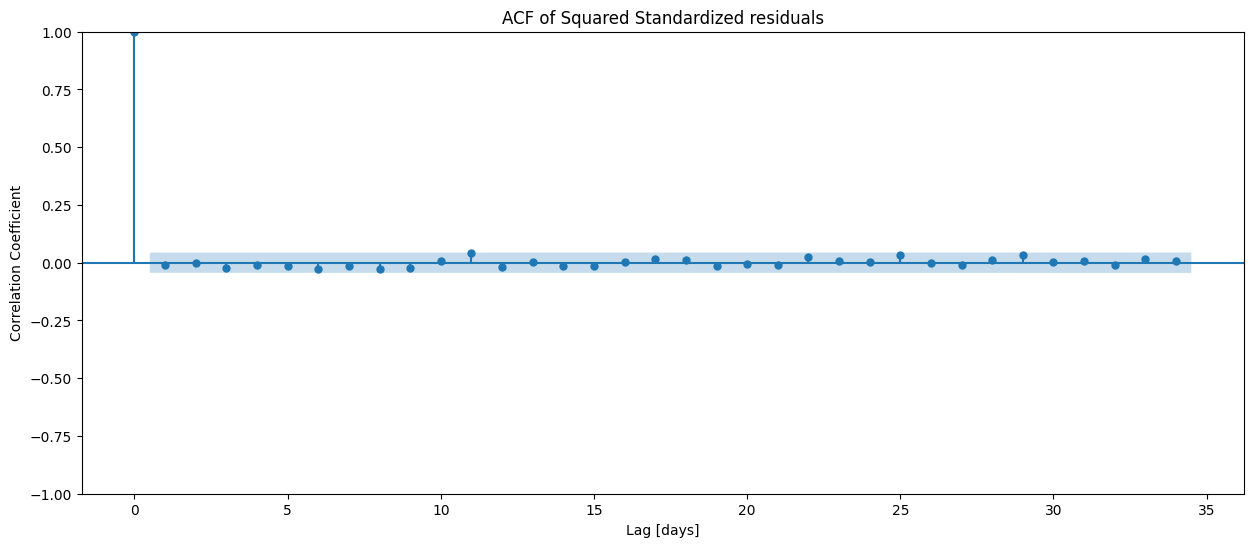

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.title('ACF of Squared Standardized residuals');

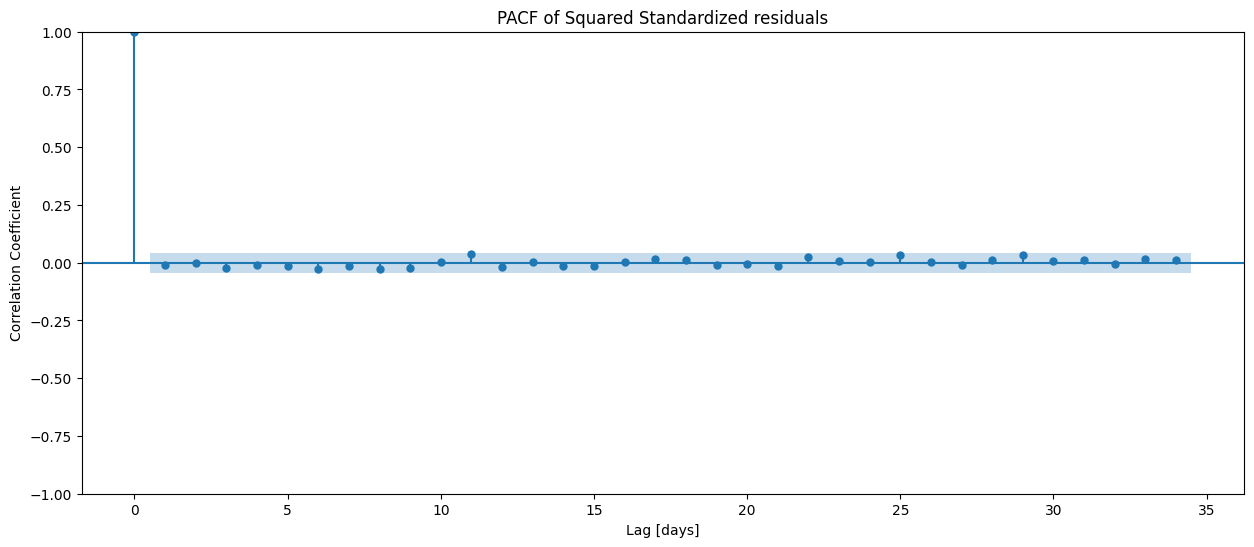

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared, standardized residuals
plot_pacf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.title('PACF of Squared Standardized residuals');

This is excellent because there is no statistically significant autocorrelation in the model's standardized residuals.

In [ ]:
#Let's make a one day forecast with the model
one_day_forecast = model.forecast(horizon=1, reindex=False).variance
one_day_forecast

h.1
date                
2023-05-18  1.674085

Note that our model forecast shows the predicted variance, not the standard deviation or volatility. So we'll need to take the square root of the value. In addition, the `h.1` column stands for "horizon 1", that is, our model's prediction for the following day (the day after and not the date shown in the table). Hence, we will need to reformat the model's forecast.

### **Walk-Forward Validation**

**Walk-forward validation** is a rigorous out-of-sample evaluation technique specifically designed for time series data where the temporal order is crucial. Instead of a single train-test split, it involves iteratively training the GARCH model on an expanding window of past data and then evaluating its performance on a fixed, subsequent period. For instance, the model might be initially trained on the first 1000 data points to forecast the next 100. Then, the training window is expanded to include the next 100 data points (now 1100 total), and the model is re-estimated to forecast the subsequent 100. This process continues, "walking forward" in time, with each iteration using more historical data for training and evaluating on a distinct, future segment. This method provides a more realistic assessment of the GARCH model's forecasting ability in a real-world scenario where the model would be continuously updated with new data, and its future performance on truly unseen data is of interest.

We will use this technique to get the predictions on the testing set.

In [ ]:
#Perform Walk-Forward Validation for the GARCH(1,1) model
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y_msft) * 0.2)

# Walk forward
for i in range(test_size):
    # Create train data
    y_train = y_msft.iloc[: -(test_size - i)]

    # Train the GARCH(1,2) model
    model = arch_model(y_train, p=1, q=2, rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0]**0.5 #Calculate the square root

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_msft.tail(test_size).index)

print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv shape: (500,)


date
2023-05-19    1.293864
2023-05-22    1.181475
2023-05-23    1.187722
2023-05-24    1.448480
2023-05-25    1.291951
dtype: float64

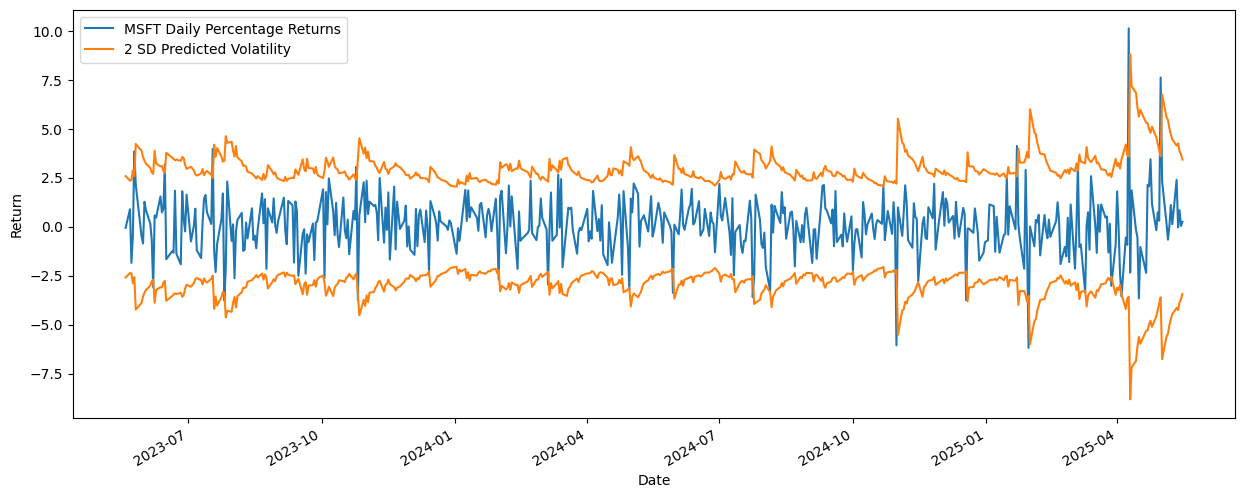

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot daily percentage returns for test data
y_msft.tail(test_size).plot(ax=ax, label="MSFT Daily Percentage Returns")

# Plot volatility predictions * 2 (upper bound)
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2 (lower bound)
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

The volatility predictions seem to follow the changes in returns over time. Next, we will plot the ACF and PACF of the standardized residuals for the test set.

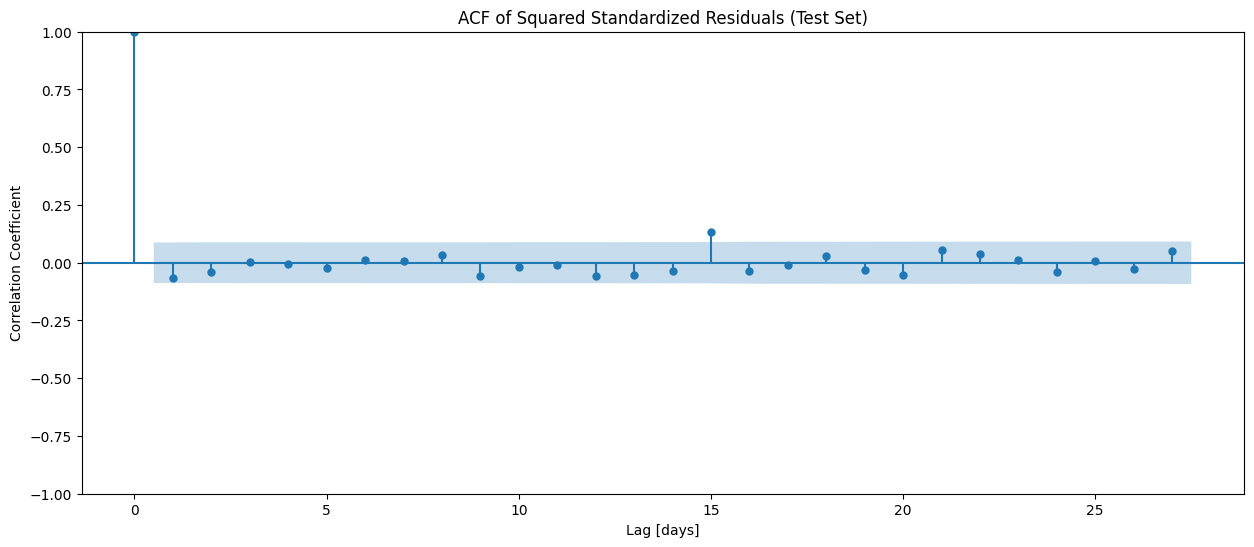

In [ ]:
# Plot ACF of squared standardized residuals for the test set period
# Get the index of the test set from y_msft
test_set_index = y_msft.tail(test_size).index

# Get the common index between the test set and model.std_resid
common_index = test_set_index.intersection(model.std_resid.index)

# Select the standardized residuals using the common index
test_resid = model.std_resid.loc[common_index]

fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals for the test set
plot_acf(test_resid**2, ax=ax)

# Add axis labels
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.title('ACF of Squared Standardized Residuals (Test Set)')

plt.show()

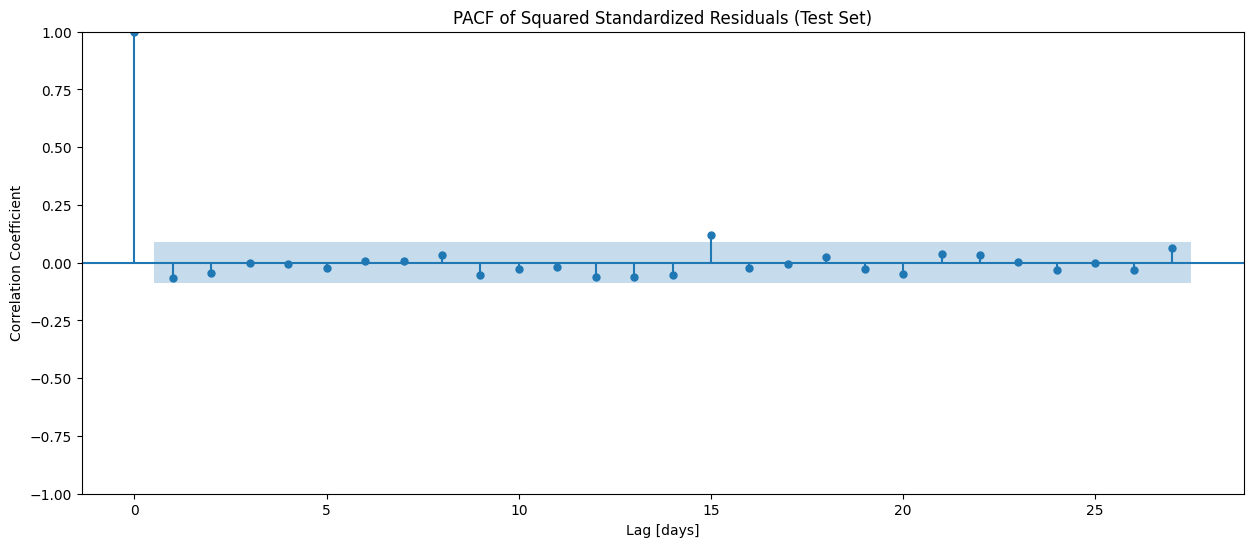

In [ ]:
# Create PACF of squared, standardized residuals for the test set
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(test_resid**2, ax=ax)

# Add axis labels
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.title('PACF of Squared Standardized Residuals (Test Set)')

plt.show()

The ACF and PACF plots of the squared standardized residuals from our GARCH(1,2) model on the MSFT test set generally shows no significant autocorrelation beyond lag 0, indicating that the model has largely captured the volatility clustering.

In [ ]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

                 h.1      h.2      h.3       h.4       h.5
date                                                      
2025-05-15  1.716133  1.75102  1.73949  1.741367  1.739435


Here, `h.1` is the volatility prediction for the next day (the day after the date shown above), `h.2` for the next two days after the date shown above, and so on. This requires us to change the format to something more comprehensive. We will create a function to combine the index and predictions, and then return a dictionary where each key is a date and each value is a predicted volatility.  But there are two things we need to keep in mind. First, we can't include dates that are weekends because no trading happens on those days. Second, we'll need to write our dates using strings that follow the ISO 8601 standard (an international standard covering the worldwide exchange and communication of date and time-related data).

In [ ]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0]+pd.DateOffset(days=1)

    # Create date range
    prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]

    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten()**0.5

    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data,index=prediction_index)

    # Return Series as dictionary
    return prediction_formatted.to_dict()

In [ ]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)
prediction_formatted

{'2025-05-16T00:00:00': 1.7161326449319563,
 '2025-05-19T00:00:00': 1.7510201391137317,
 '2025-05-20T00:00:00': 1.739489622293452,
 '2025-05-21T00:00:00': 1.7413669713175841,
 '2025-05-22T00:00:00': 1.7394345544359233,
 '2025-05-23T00:00:00': 1.7386672072936342,
 '2025-05-26T00:00:00': 1.737625585644653,
 '2025-05-27T00:00:00': 1.7367225157013897,
 '2025-05-28T00:00:00': 1.7358360218671827,
 '2025-05-29T00:00:00': 1.7349986955881784}

We can see that some dates are not included  because they are weekends. This shows that we have successfully cleaned the predictions.

## **Model Deployment**

To deploy our model using FastAPI and Web Interface, we will need to structure our codes into modules to make the coding process cleaner and easier to maintain. We are going to build those modules one after the other.


### **1. config.py**

This module manages the application's configuration settings, such as API keys and database locations, using environment variables. This module will contain the `Settings` class (as seen earlier) that will use Pydantic's BaseSettings to manage application settings, loading configuration variables (like API keys and database names) from environment variables.

In [ ]:
%%writefile config.py

from pydantic_settings import BaseSettings


def get_db_path(db_name: str = "stocks.sqlite") -> str:
    """Constructs the full path to the SQLite database file."""

    # Get the current working directory
    base_dir = os.getcwd()
    # Join the base directory and database name to create the full path
    db_path = os.path.join(base_dir, db_name)
    return db_path

class Settings(BaseSettings):
    ngrok_token: str
    alpha_api_key: str
    db_name: str
    model_directory: str

    class Config:
        env_file = ".env"


# Create instance of `Settings` class
settings = Settings()

Writing config.py


In [ ]:
# Import settings from the config module
from config import settings

# Print the database name from the settings
print(settings.db_name)

stocks.sqlite


### **2. etl.py**

This module will handle the extraction of stock data from the AlphaVantage API and the loading of this data into a SQLite database. This module is going to contain the following classes:

* **`AlphaVantageAPI`**: This class (as earlier seen) will be responsible for fetching stock data from the AlphaVantage API, with the `get_daily` method retrieving daily time series data for a given stock ticker.

* **`SQLRepository`**: This class (as earlier seen) will handle database operations using SQLite, with the `insert_table` method inserting data into a table and the `read_table` method retrieving data from a specified table.

Once you run the cell below, the code in the cell will be automatically saved to the file named `etl.py`. This is made possible by the `%%writefile` line.





In [ ]:
%%writefile etl.py

import sqlite3
import pandas as pd
import requests
from config import settings

class AlphaVantageAPI:
    def __init__(self, api_key=settings.alpha_api_key):
        self.__api_key=api_key


    def get_daily(self, ticker,output_size='full'):

        """Get daily time series of an equity from AlphaVantage API.

        Parameters
        ----------
        ticker : str
            The ticker symbol of the equity.
        output_size : str, optional
            Number of observations to retrieve. "compact" returns the
            latest 100 observations. "full" returns all observations for
            equity. By default "full".

        Returns
        -------
        pd.DataFrame
            Columns are 'open', 'high', 'low', 'close', and 'volume'.
            All are numeric.
        """
        # Create URL
        url = (
            "https://www.alphavantage.co/query?"
            "function=TIME_SERIES_DAILY&"
            f"symbol={ticker}&"
            f"outputsize={output_size}&"
            f"datatype=json&"
            f"apikey={self.__api_key}"
        )

        # Send request to API
        response = requests.get(url=url)

        # Extract JSON data from response
        response_data = response.json()

        #Include Exception for bad ticker symbol
        if 'Time Series (Daily)' not in response_data.keys():
            raise Exception (
                f'Invalid API call. Check that ticker symbol {ticker} is correct.'
            )

        # Read data into DataFrame
        stock_data = response_data["Time Series (Daily)"]
        df = pd.DataFrame.from_dict(stock_data,orient='index',dtype=float)

        # Convert index to `DatetimeIndex` named "date"
        df.index = pd.to_datetime(df.index)
        df.index.name = 'date'

        # Remove numbering from columns
        df.columns = [c.split('. ')[1] for c in df.columns]

        # Return DataFrame
        return df



class SQLRepository:
    def __init__(self, connection):
        self.connection=connection



    def insert_table(self, table_name, records, if_exists='fail'):

        """Insert DataFrame into SQLite database as table

        Parameters
        ----------
        table_name : str
        records : pd.DataFrame
        if_exists : str, optional
            How to behave if the table already exists.

            - 'fail': Raise a ValueError.
            - 'replace': Drop the table before inserting new values.
            - 'append': Insert new values to the existing table.

            Dafault: 'fail'

        Returns
        -------
        dict
            Dictionary has two keys:

            - 'transaction_successful', followed by bool
            - 'records_inserted', followed by int
        """

        n_inserted = records.to_sql(
                name = table_name,
                con = self.connection,
                if_exists = if_exists
        )
        return {'transaction_successful':True,
               'records_inserted':n_inserted
               }

    def read_table(self, table_name, limit = None):

        """Read table from database.

        Parameters
        ----------
        table_name : str
            Name of table in SQLite database.
        limit : int, None, optional
            Number of most recent records to retrieve. If `None`, all
            records are retrieved. By default, `None`.

        Returns
        -------
        pd.DataFrame
            Index is DatetimeIndex "date". Columns are 'open', 'high',
            'low', 'close', and 'volume'. All columns are numeric.
        """
        # Create SQL query (with optional limit)
        if limit:
            sql = f"SELECT * FROM '{table_name}' LIMIT {limit}"
        else:
            sql = f"SELECT * FROM '{table_name}'"


        # Retrieve data, read into DataFrame
        df = pd.read_sql(sql=sql, con=self.connection,
                        parse_dates=['date'], index_col='date')

        # Return DataFrame
        return df

Writing etl.py


Now we can make use of the `AlphaVantageAPI` after importing it.

In [ ]:
# Import `AlphaVantageAPI`
from etl import AlphaVantageAPI

# Create instance of `AlphaVantageAPI` class
av= AlphaVantageAPI()

# Define WTI ticker symbol
ticker = "WTI" #West Texas Intermediate Crude

# Use your `av` object to get daily data
df_wti = av.get_daily(ticker=ticker)

print("df_wti shape:", df_wti.shape)
df_wti.head()

df_wti shape: (5108, 5)


open  high   low  close     volume
date                                          
2025-05-16  1.45  1.48  1.42   1.46   958267.0
2025-05-15  1.51  1.52  1.45   1.45  1603855.0
2025-05-14  1.58  1.60  1.54   1.56  1649248.0
2025-05-13  1.48  1.60  1.46   1.60  2013358.0
2025-05-12  1.45  1.51  1.41   1.48  2874603.0

### **3. model.py**

This module will define the GARCH model, including its training, prediction, saving, and loading functionalities. This module is going to contain the **`GarchModel`** class that will encapsulate the logic for training a GARCH model and generating volatility predictions, using methods like `wrangle_data` to prepare data, `fit` to train the model, `predict_volatility` to make predictions, `dump` to save the model, and `load` to retrieve a saved model.

Once you run the cell below, the code in the cell will be automatically saved to the file named `model.py`. This is made possible by the `%%writefile` line.

In [ ]:
%%writefile model.py
from etl import AlphaVantageAPI, SQLRepository
from pathlib import Path
import pickle
from config import settings
from arch import arch_model
import pandas as pd
import os
import joblib
from glob import glob


class GarchModel:
    """Class for training GARCH model and generating predictions.

    Atttributes
    -----------
    ticker : str
        Ticker symbol of the equity whose volatility will be predicted.
    repo : SQLRepository
        The repository where the training data will be stored.
    use_new_data : bool
        Whether to download new data from the AlphaVantage API to train
        the model or to use the existing data stored in the repository.
    model_directory : str
        Path for directory where trained models will be stored.

    Methods
    -------
    wrangle_data
        Generate equity returns from data in database.
    fit
        Fit model to training data.
    predict
        Generate volatilty forecast from trained model.
    dump
        Save trained model to file.
    load
        Load trained model from file.
    """

    def __init__(self, ticker, repo, use_new_data):

        self.ticker = ticker
        self.repo = repo
        self.use_new_data = use_new_data
        self.model_directory = settings.model_directory

    def wrangle_data(self, n_observations):

        """Extract data from database (or get from AlphaVantage), transform it
        for training model, and attach it to `self.data`.

        Parameters
        ----------
        n_observations : int
            Number of observations to retrieve from database

        Returns
        -------
        None
        """
        # Add new data to database if required
        if self.use_new_data:

            #Instantiate an API class
            api = AlphaVantageAPI()

            #Get Data
            new_data =api.get_daily(ticker=self.ticker)

            #Insert new data into repo
            self.repo.insert_table(
                table_name=self.ticker,
                records=new_data,
                if_exists='replace')

        # Pull data from SQL database
        df = self.repo.read_table(table_name=self.ticker,
                                 limit=n_observations+1)

        # Clean data, attach to class as `data` attribute
        df.sort_index(ascending=True, inplace=True)
        df['return']=df['close'].pct_change()*100

        self.data = df['return'].dropna()

    def fit(self, p, q):

        """Create model, fit to `self.data`, and attach to `self.model` attribute.
        For assignment, also assigns adds metrics to `self.aic` and `self.bic`.

        Parameters
        ----------
        p : int
            Lag order of the symmetric innovation

        q : ind
            Lag order of lagged volatility

        Returns
        -------
        None
        """
        # Train Model, attach to `self.model`
        self.model = arch_model(self.data, p=p, q=q, rescale=False).fit(disp=0)
        # Add AIC and BIC attributes
        self.aic = self.model.aic
        self.bic = self.model.bic


    def __clean_prediction(self, prediction):

        """Reformat model prediction to JSON.

        Parameters
        ----------
        prediction : pd.DataFrame
            Variance from a `ARCHModelForecast`

        Returns
        -------
        dict
            Forecast of volatility. Each key is date in ISO 8601 format.
            Each value is predicted volatility.
        """
        # Calculate forecast start date
        start = prediction.index[0]+pd.DateOffset(days=1)

        # Create date range
        prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

        # Create prediction index labels, ISO 8601 format
        prediction_index = [d.isoformat() for d in prediction_dates]

         # Extract predictions from DataFrame, get square root
        data = prediction.values.flatten()**0.5

        # Combine `data` and `prediction_index` into Series
        prediction_formatted = pd.Series(data,index=prediction_index)

        # Return Series as dictionary
        return prediction_formatted.to_dict()
        return ...

    def predict_volatility(self, horizon):

        """Predict volatility using `self.model`

        Parameters
        ----------
        horizon : int
            Horizon of forecast, by default 5.

        Returns
        -------
        dict
            Forecast of volatility. Each key is date in ISO 8601 format.
            Each value is predicted volatility.
        """
        # Generate variance forecast from `self.model`
        prediction = self.model.forecast(horizon=horizon, reindex=False).variance

        # Format prediction with `self.__clean_predction`
        prediction_formatted = self.__clean_prediction(prediction)

        # Return `prediction_formatted`
        return prediction_formatted


    def dump(self):

        """Save model to `self.model_directory` with timestamp.

        Returns
        -------
        str
            filepath where model was saved.
        """
        # Create timestamp in ISO format
        timestamp = pd.Timestamp.now().isoformat()
        # Create filepath, including `self.model_directory`
        filepath = os.path.join(self.model_directory, f"{timestamp}_{self.ticker}.pkl")
        # Save `self.model`
        joblib.dump(self.model, filepath)
        # Return filepath
        return filepath


    def load(self):

        """Load most recent model in `self.model_directory` for `self.ticker`,
        attach to `self.model` attribute.

        """
        # Create pattern for glob search
        pattern = os.path.join(self.model_directory, f"*{self.ticker}.pkl")
        # Use glob to get most recent model, handle errors
        try:
            model_path = sorted(glob(pattern))[-1]
        except IndexError:
            raise Exception(f"No model trained for '{ticker}'.")
        # Load model and attach to `self.model`
        self.model = joblib.load(model_path)

Writing model.py


In [ ]:
from model import GarchModel

# Instantiate a `GarchModel`
gm_msft = GarchModel(ticker="MSFT", repo=repo, use_new_data=False)

# Wrangle data
gm_msft.wrangle_data(n_observations=1000)


print(gm_msft.data.shape)
print()
print(gm_msft.data.head())

(1000,)

date
2021-05-25    0.374831
2021-05-26   -0.091371
2021-05-27   -0.866834
2021-05-28    0.148410
2021-06-01   -0.913169
Name: return, dtype: float64


In [ ]:
# Fit GARCH(1,2) model to MSFT data
gm_msft.fit(p=1, q=2)

# Check model parameters
gm_msft.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1895.17
Distribution:                  Normal   AIC:                           3800.34
Method:            Maximum Likelihood   BIC:                           3824.88
                                        No. Observations:                 1000
Date:                Sun, May 18 2025   Df Residuals:                      999
Time:                        11:24:37   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1208  4.999e-02      2.417  1.564e-02 [2.286e-02,  0.219]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0345  1.667e-02      2.072  3.826e-02  [1.868e-03,6.720e-02]
alpha[1]       0.0468  1.382e-02      3.388  7.038e-04  [1.974e-02,7.394e-02]
beta[1]        0.0262  2.668e-02      0.982      0.326 [-2.609e-02,7.849e-02]
beta[2]        0.9182  2.622e-02     35.021 1.082e-268      [  0.867,  0.970]
=============================================================================

Covariance estimator: robust
"""

In [ ]:
# Generate 5-day volatility prediction from `gm_msft`
prediction = gm_msft.predict_volatility(horizon=5)
prediction

{'2025-05-19T00:00:00': 2.1554249610141634,
 '2025-05-20T00:00:00': 2.180302006408631,
 '2025-05-21T00:00:00': 2.155801094202978,
 '2025-05-22T00:00:00': 2.17686782568513,
 '2025-05-23T00:00:00': 2.1558929347710327}

In [ ]:
# Save `gm_msft` model and assign filename
filename = gm_msft.dump()
filename

'models/2025-05-18T11:24:40.294111_MSFT.pkl'

If you check your `models` folder, you will notice that the model has been saved in it.

In [ ]:
#Test load function that will take a ticker symbol as input and return a model
gm_msft.load()
gm_msft.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1895.17
Distribution:                  Normal   AIC:                           3800.34
Method:            Maximum Likelihood   BIC:                           3824.88
                                        No. Observations:                 1000
Date:                Sun, May 18 2025   Df Residuals:                      999
Time:                        11:24:37   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1208  4.999e-02      2.417  1.564e-02 [2.286e-02,  0.219]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0345  1.667e-02      2.072  3.826e-02  [1.868e-03,6.720e-02]
alpha[1]       0.0468  1.382e-02      3.388  7.038e-04  [1.974e-02,7.394e-02]
beta[1]        0.0262  2.668e-02      0.982      0.326 [-2.609e-02,7.849e-02]
beta[2]        0.9182  2.622e-02     35.021 1.082e-268      [  0.867,  0.970]
=============================================================================

Covariance estimator: robust
"""

### **4. main.py**

This module will set up the FastAPI application to serve the GARCH model, defining API endpoints for fitting the model, generating volatility predictions, and calculating historical volatility. This module is going to contain the following classes:

* `FitIn`: Will define the data structure for input when fitting the model, including ticker, data usage, number of observations, and GARCH parameters.

* `FitOut`: Will define the data structure for the output after fitting a model, adding success status and a message to the `FitIn` structure.

* `PredictIn`: Will define the data structure for input when requesting a prediction, including ticker and number of days to forecast.

* `PredictOut`: Will define the data structure for the prediction output, adding success status, the forecast dictionary, and a message to the `PredictIn` structure.

* `HistoricalVolatilityIn`: Will define the data structure for requesting historical volatility, including ticker, number of observations, window size, and period.

* `HistoricalVolatilityOut`: Will define the data structure for the historical volatility output, including input data, success status, historical volatility data, and a message.


Once you run the cell below, the code in the cell will be automatically saved to the file named `main.py`. This is made possible by the `%%writefile` line.



In [ ]:
%%writefile main.py

from fastapi import FastAPI, HTTPException, status
from model import GarchModel
from pydantic import BaseModel
import pickle
import json
import uvicorn
from pyngrok import ngrok
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio
import sqlite3
from config import settings
from etl import SQLRepository

# 'FitIn' class
class FitIn(BaseModel):
    ticker: str
    use_new_data: bool
    n_observations: int
    p: int
    q: int



# 'FitOut' class
class FitOut(FitIn):
    success: bool
    message: str


# 'PredictIn' class
class PredictIn(BaseModel):
    ticker: str
    n_days: int


# 'PredictOut' class
class PredictOut(PredictIn):
    success: bool
    forecast: dict
    message: str


# Function to build the model
def build_model(ticker, use_new_data):

    # Create DB connection
    connection = sqlite3.connect(settings.db_name, check_same_thread=False)

    # Create `SQLRepository`
    repo = SQLRepository(connection=connection)

    # Create model
    model = GarchModel(ticker=ticker, use_new_data=use_new_data, repo=repo)

    # Return model
    return model


# Instantiate FastAPI
app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Allows all origins
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)


# Create "/hello" path
@app.get('/hello',status_code=200)
def hello():
    """Return dictionary with greeting message."""
    return {'message': 'Hello World!'}


@app.post('/fit', status_code=200, response_model=FitOut)
# Create "/fit" path
def fit_model(request:FitIn):

    """Fit model, return confirmation message.

    Parameters
    ----------
    request : FitIn

    Returns
    ------
    dict
        Must conform to `FitOut` class
    """
    # Create `response` dictionary from `request`
    response = request.dict()

    # Create try block to handle exceptions
    try:
        # Build model with `build_model` function
        model = build_model(ticker=request.ticker, use_new_data=request.use_new_data)

        # Wrangle data
        model.wrangle_data(n_observations=request.n_observations)

        # Fit model
        model.fit(p=request.p, q=request.q)

        # Save model
        filename = model.dump()

        # Add `"success"` key to `response`
        response['success'] = True


        # Add `"message"` key to `response` with `filename`
        response['message'] = f"GarchModel successfully trained and saved to {filename}. GarchModel scores are: AIC: {model.aic:.2f}, BIC: {model.bic:.2f}. Note that lower AIC and BIC scores implies better model performance"

    # Create except block
    except Exception as e:
        # Add `"success"` key to `response`
        response['success'] = False

        # Add `"message"` key to `response` with error message
        response['message'] = str(e)

    # Return response
    return response

@app.post('/predict', status_code=200, response_model=PredictOut)
# Create "/predict" path
def get_prediction(request:PredictIn):

    # Create `response` dictionary from `request`
    response = request.dict()

    # Create try block to handle exceptions
    try:
        # Build model with `build_model` function
        model = build_model(ticker=request.ticker, use_new_data= False)

        # Load stored model
        model.load()

        # Generate prediction
        prediction = model.predict_volatility(horizon=request.n_days)

        # Add `"success"` key to `response`
        response['success'] = True

        # Add `"forecast"` key to `response`
        response['forecast'] = prediction

        # Add `"message"` key to `response`
        response['message'] = ""

    # Create except block
    except Exception as e:
        # Add `"success"` key to `response`
        response['success'] = False

        # Add `"forecast"` key to `response`
        response['forecast'] = {}

        #  Add `"message"` key to `response`
        response['message'] = str(e)

    # Return response
    return response

class HistoricalVolatilityIn(BaseModel):
    ticker: str
    n_observations: int = 1000
    window_size: int = 21
    period: str = "Days"  # Options: Days, Months, Years

class HistoricalVolatilityOut(HistoricalVolatilityIn):
    success: bool
    historical_vol: dict
    message: str

@app.post('/historical_volatility', status_code=200, response_model=HistoricalVolatilityOut)
# Create "/historical_volatility" path
def historical_volatility(request: HistoricalVolatilityIn):

    response = request.dict()
    try:
        # Build model (using new data to get the latest history)
        model = build_model(ticker=request.ticker, use_new_data=True)
        # Retrieve historical data
        model.wrangle_data(n_observations=request.n_observations)
        # Convert window size based on period selection
        if request.period.lower() == "days":
            window = request.window_size
        elif request.period.lower() == "months":
            window = request.window_size * 21  # Approx. 21 trading days per month
        elif request.period.lower() == "years":
            window = request.window_size * 252  # Approx. 252 trading days per year
        else:
            window = request.window_size

        # Compute rolling volatility as the standard deviation of returns
        rolling_vol = model.data.rolling(window=window).std()

        # Drop NaNs and convert to dictionary
        response['historical_vol'] = rolling_vol.dropna().to_dict()
        response['success'] = True
        response['message'] = "Historical volatility computed successfully."
    except Exception as e:
        response['success'] = False
        response['historical_vol'] = {}
        response['message'] = str(e)
    return response


Writing main.py


In [ ]:
#Testing the build_model function in the main module
from main import build_model

# Instantiate `GarchModel` with the 'build_model' function
model_msft = build_model(ticker="TSLA", use_new_data=False)

model_msft

Running our FastAPI application inside an interactive environment like Google Colab blocks other cells from being executed. To run the app without blocking the main thread, we are going to spin up Uvicorn in a background thread. This will allow us to continue to run other cells while the API server is live.

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import pickle
import json
import uvicorn
from pyngrok import ngrok
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio
import threading
import asyncio

# Import your FastAPI app
from main import app

def run_uvicorn():
    """Run Uvicorn server in a separate thread so that other cells won't be blocked."""
    config = uvicorn.Config(
        "main:app",
        host="0.0.0.0",
        port=8008,
        reload=True,
        workers=1,
    )
    server = uvicorn.Server(config)

    # Use nest_asyncio to make Uvicorn compatible with Colab's event loop
    nest_asyncio.apply()

    # Start the Uvicorn server in a separate thread
    loop = asyncio.get_event_loop()
    loop.run_until_complete(server.serve())


# Start the server in a background thread
thread = threading.Thread(target=run_uvicorn)
thread.start()

INFO:     Will watch for changes in these directories: ['/content']


We are going to use `ngrok` to create a public, shareable URL that points to our FastAPI application running locally port `8008`. By visiting this ngrok URL, anyone can access our FastAPI application over the internet, even if it's running on our local machine.

In [ ]:
from dotenv import load_dotenv

load_dotenv()
NGROK_ATK = os.getenv('NGROK_TOKEN')

# Set your authtoken
ngrok.set_auth_token(NGROK_ATK)

# connect to the FastAPI app running on port 8008
ngrok_tunnel = ngrok.connect(8008)
print('FastAPI URL:', ngrok_tunnel.public_url)

FastAPI URL: https://175c-34-125-65-15.ngrok-free.app


If we add **/docs** at the end of the ngrok URL in a browser (e.g. Chrome, Firefox) and press Enter, it will take us to the Swagger UI documentation of our FastAPI application. This Swagger UI documentation provides a user-friendly way to interact with and understand our FastAPI application's functionality. We will be able to see all the available endpoints for our application, and understand the expected input and output formats for each endpoint.

For example, `https://3fc6-35-237-229-37.ngrok-free.app/docs`

In [ ]:
# Paste the ngrok URL before the /hello path
url = "https://e694-34-125-65-15.ngrok-free.app/hello"
response = requests.get(url=url)

print("response code:", response.status_code)

if response.status_code == 200:
    print(response.json())
else:
    print("Request failed with status code:", response.status_code)
    print("Response content:", response.text)

INFO:     34.125.65.15:0 - "GET /hello HTTP/1.1" 200 OK
response code: 200
{'message': 'Hello World!'}


The response code 200 indicates that we have successfully hit the `/hello` path

In [ ]:
# URL of `/fit` path
url = "https://3fc6-35-237-229-37.ngrok-free.app/fit"

# Data to send to path
json = {"ticker": "TSLA",
          "use_new_data": False,
          "n_observations": 2000,
          "p":1,
          "q":1}
# Response of post request
response = requests.post(url=url, json=json)
# Inspect response
print("response code:", response.status_code)
response.json()

INFO:     35.237.229.37:0 - "POST /fit HTTP/1.1" 200 OK
response code: 200


{'ticker': 'TSLA',
 'use_new_data': False,
 'n_observations': 2000,
 'p': 1,
 'q': 1,
 'success': True,
 'message': 'GarchModel successfully trained and saved to models/2025-05-17T18:32:17.992169_TSLA.pkl. GarchModel scores are: AIC: 11606.71, BIC: 11629.11. Note that lower AIC and BIC scores implies better model performance'}

In [ ]:
# URL of `/predict` path
url = "https://3fc6-35-237-229-37.ngrok-free.app/predict"

# Data to send to path
json = {"ticker": "TSLA", "n_days": 5}
# Response of post request
response = requests.post(url=url, json=json)
# Response in JSON
response.json()

INFO:     35.237.229.37:0 - "POST /predict HTTP/1.1" 200 OK


{'ticker': 'TSLA',
 'n_days': 5,
 'success': True,
 'forecast': {'2025-05-19T00:00:00': 5.47999607370238,
  '2025-05-20T00:00:00': 5.486804957631687,
  '2025-05-21T00:00:00': 5.493604776467374,
  '2025-05-22T00:00:00': 5.500395563886981,
  '2025-05-23T00:00:00': 5.507177353357387},
 'message': ''}

### **5. dash_app.py**

 This module will be used to create the Dash application, providing a user interface to interact with the FastAPI API for fitting models, predicting volatility, and visualizing historical data.

In [ ]:
#install the dash package
!pip install dash dash-bootstrap-components requests plotly

Insert your ngrok URL for your FastAPI below

In [ ]:
%%writefile dash_app.py

import dash
from dash import dcc, html, Input, Output, State, callback
import dash_bootstrap_components as dbc
import requests
import plotly.graph_objs as go

# Initialize Dash app
dash_app = dash.Dash(__name__, external_stylesheets=[dbc.themes.LUX])
server = dash_app.server

# Insert your API ngrok URL here
FASTAPI_URL = "https://175c-34-125-65-15.ngrok-free.app"

# App layout
dash_app.layout = dbc.Container([
    # Header Section
    html.Div([
        html.H1("📈 Stock Volatility Predictor", className="text-center text-primary fw-bold"),
        html.P("Analyze and forecast stock volatility using the GARCH model with just a few clicks.",
               className="text-center text-secondary fs-5"),
        html.P("This application allows you to select a stock ticker and configure the GARCH model parameters to predict stock volatility. "
               "You can fit the model using past observations and generate forecasts for future volatility.",
               className="text-center text-muted")
    ], className="mb-4 p-3 bg-light rounded shadow"),

    # Historical & Rolling Volatility Section
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardHeader(html.H4("📉 Historical & Rolling Volatility", className="text-center bg-info text-white")),
                dbc.CardBody([
                    html.P("Get historical volatility and view rolling volatility for a selected period.", className="text-muted"),
                    html.Label("Stock Ticker", className="fw-bold"),
                    dcc.Input(
                        id='ticker-input-hist',
                        type='text',
                        placeholder="Enter ticker (e.g., AAPL)",
                        className='mb-3 form-control',
                        style={"border-radius": "10px"}
                    ),
                    html.Label("Rolling Window Size", className="fw-bold"),
                    dbc.Input(id='window-size-input', type='number', value=31, className='form-control mb-3',
                              style={"border-radius": "10px"}),
                    html.Label("Period", className="fw-bold"),
                    dcc.Dropdown(
                        id='period-dropdown',
                        options=[
                            {'label': 'Days', 'value': 'Days'},
                            {'label': 'Months', 'value': 'Months'},
                            {'label': 'Years', 'value': 'Years'}
                        ],
                        value='Days',
                        clearable=False,
                        className='mb-3'
                    ),
                    dbc.Button("Get Historical Volatility", id='historical-button', color='info', className='w-100'),
                    # New alert for error messages in the historical section:
                    dbc.Alert("⚠️ Please enter a valid ticker symbol!", id='historical-alert', color='danger', dismissable=True, is_open=False, className="mt-3"),
                    dcc.Graph(id='historical-vol-plot', config={'displayModeBar': False},
                              style={'height': '600px', 'width': '100%'},
                              className="mt-3"
                              )
                ])
            ], className="shadow-lg p-3 mb-5 bg-white rounded")
        ], md=8, className="mx-auto"),
    ]),


    # Model Configuration Section
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardHeader(html.H4("🔧 Configure Your Model", className="text-center bg-primary text-white")),
                dbc.CardBody([
                    html.P("Enter the stock ticker (e.g., AAPL, TSLA) to fetch historical data.", className="text-muted"),
                    html.Label("Stock Ticker", className="fw-bold"),
                    dcc.Input(
                        id='ticker-input',
                        type='text',
                        className='mb-3 form-control',
                        style={"border-radius": "10px"}
                    ),
                    dbc.Alert("⚠️ Please enter a valid stock ticker!", id='ticker-alert', color='danger',
                              dismissable=True, is_open=False),
                    html.P("Set the GARCH model parameters 'p' and 'q' to define the lag structure of the model.",
                           className="text-muted"),
                    html.Label("GARCH Order p", className="fw-bold"),
                    dbc.Input(id='p-input', type='number', value=1, className='form-control mb-3',
                              style={"border-radius": "10px"}),
                    html.Label("GARCH Order q", className="fw-bold"),
                    dbc.Input(id='q-input', type='number', value=2, className='form-control mb-3',
                              style={"border-radius": "10px"}),
                    html.P("Specify the number of past observations to train the model (e.g., 1000).",
                           className="text-muted"),
                    html.Label("Number of Observations", className="fw-bold"),
                    dbc.Input(id='obs-input', type='number', value=1000, className='form-control mb-3',
                              style={"border-radius": "10px"}),
                    dbc.Button("🚀 Fit Model", id='fit-button', color='primary', className='w-100'),
                    html.Div(id='fit-status', className='mt-3 text-center fw-bold')
                ])
            ], className="shadow-lg p-3 mb-5 bg-white rounded")
        ], md=6, className="mx-auto"),
    ]),

    # Volatility Forecast Section
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardHeader(html.H4("📊 Volatility Forecast", className="text-center bg-success text-white")),
                dbc.CardBody([
                    dcc.Graph(id='volatility-plot', config={'displayModeBar': False},
                              style={'height': '600px', 'width': '100%'},
                              className="mb-3"
                              ),
                    html.P("Specify how many days ahead you want to forecast the stock's volatility.", className="text-muted"),
                    html.Label("Forecast Days", className="fw-bold"),
                    dbc.Input(id='days-input', type='number', value=5, className='form-control mb-3',
                              style={"border-radius": "10px"}),
                    dbc.Alert("⚠️ Please enter a valid stock ticker before generating a prediction!",
                              id='prediction-alert', color='danger', dismissable=True, is_open=False),
                    dbc.Button("🔮 Generate Prediction", id='predict-button', color='success', className='w-100'),
                    html.Div(id='prediction-status', className='mt-3 text-center fw-bold'),
                    html.Div(id='model-metrics', className='mt-3 text-center text-dark fw-bold')
                ])
            ], className="shadow-lg p-3 mb-5 bg-white rounded")
        ], md=8, className="mx-auto"),
    ])
], fluid=True)

# Callback for model fitting
@dash_app.callback(
    [Output('fit-status', 'children'), Output('ticker-alert', 'is_open')],
    Input('fit-button', 'n_clicks'),
    [State('ticker-input', 'value'),
     State('p-input', 'value'),
     State('q-input', 'value'),
     State('obs-input', 'value')],
    prevent_initial_call=True
)
def fit_model(n_clicks, ticker, p, q, obs):
    if not ticker:
        return "", True

    payload = {
        "ticker": ticker.upper(),
        "use_new_data": True,
        "n_observations": obs,
        "p": p,
        "q": q
    }
    try:
        response = requests.post(f"{FASTAPI_URL}/fit", json=payload)
        if response.status_code == 200:
            result = response.json()
            if result['success']:
                return dbc.Alert(f"✅ Model trained successfully! {result['message']}", color="success"), False
            return dbc.Alert(f"❌ Training failed: {result['message']}", color="danger"), False
        return dbc.Alert(f"⚠️ API Error: {response.status_code}", color="danger"), False
    except Exception as e:
        return dbc.Alert(f"🔴 Connection error: {str(e)}", color="danger"), False

# Callback for predictions
@dash_app.callback(
    [Output('volatility-plot', 'figure'), Output('prediction-status', 'children'),
     Output('prediction-alert', 'is_open')],
    Input('predict-button', 'n_clicks'),
    [State('ticker-input', 'value'),
     State('days-input', 'value')],
    prevent_initial_call=True
)
def make_prediction(n_clicks, ticker, days):
    if not ticker:
        return go.Figure(), "", True

    payload = {"ticker": ticker.upper(), "n_days": days}
    try:
        response = requests.post(f"{FASTAPI_URL}/predict", json=payload)
        if response.status_code == 200:
            result = response.json()
            if result['success']:
                dates = list(result['forecast'].keys())
                values = list(result['forecast'].values())
                fig = go.Figure(
                    data=[go.Scatter(x=dates, y=values, mode='lines+markers')],
                    layout={'title': f'📉 {ticker.upper()} Volatility Forecast',
                            'xaxis': {'title': 'Date'},
                            'yaxis': {'title': 'Volatility'}}
                )
                return fig, dbc.Alert("✅ Prediction generated successfully!", color="success"), False
            return go.Figure(), dbc.Alert(f"❌ Prediction failed: {result['message']}", color="danger"), False
        return go.Figure(), dbc.Alert(f"⚠️ API Error: {response.status_code}", color="danger"), False
    except Exception as e:
        return go.Figure(), dbc.Alert(f"🔴 Connection error: {str(e)}", color="danger"), False

# Callback for Historical & Rolling Volatility
@dash_app.callback(
    [Output('historical-vol-plot', 'figure'),
     Output('historical-alert', 'children'),
     Output('historical-alert', 'is_open')],
    Input('historical-button', 'n_clicks'),
    [State('ticker-input-hist', 'value'),
     State('window-size-input', 'value'),
     State('period-dropdown', 'value')],
    prevent_initial_call=True
)
def update_historical_vol(n_clicks, ticker, window_size, period):
    if not ticker:
        # Return an empty figure and open the alert with a message
        return go.Figure(), "⚠️ Please enter a ticker symbol", True

    payload = {
        "ticker": ticker.upper(),
        "n_observations": 1000,
        "window_size": window_size,
        "period": period
    }
    try:
        response = requests.post(f"{FASTAPI_URL}/historical_volatility", json=payload)
        if response.status_code == 200:
            result = response.json()
            if result['success']:
                vol_dict = result['historical_vol']
                dates = list(vol_dict.keys())
                vol_values = list(vol_dict.values())
                fig = go.Figure(
                    data=[go.Scatter(x=dates, y=vol_values, mode='lines+markers')],
                    layout={'title': f'Historical Rolling Volatility for {ticker.upper()}',
                            'xaxis': {'title': 'Date'},
                            'yaxis': {'title': 'Volatility'}}
                )
                # Hide the alert when successful
                return fig, "", False
            else:
                # Error from the endpoint; display its message in the alert
                return go.Figure(), f"❌ {result['message']}", True
        else:
            return go.Figure(), f"⚠️ API Error: {response.status_code}", True
    except Exception as e:
        return go.Figure(), f"🔴 Connection error: {str(e)}", True


if __name__ == '__main__':
    dash_app.run(host="0.0.0.0", port=8050, debug=True)



Overwriting dash_app.py


We are going to run the cell below to start the Dash application in our `dash_app.py` module in a quiet mode (no output in the terminal) and in the background, allowing us to continue working in the notebook while the app runs.

In [ ]:
# Start the Dash app in the dash_app module
!python dash_app.py &>/dev/null &

In [ ]:
# Create the ngrok URL for the Dash app
load_dotenv()
NGROK_ATK = os.getenv('NGROK_TOKEN')

# Set your authtoken
ngrok.set_auth_token(NGROK_ATK)

# Connect to the Dash app running on port 8050
ngrok_tunnel = ngrok.connect(8050)
print('Dash App URL:', ngrok_tunnel.public_url)

Dash App URL: https://ec55-34-125-65-15.ngrok-free.app


## **Conclusion**

In this project, we have successfully demonstrated how advanced statistical modeling and modern API development can be combined to create a practical tool for financial analysis. By applying the GARCH model to forecast stock market volatility, the system offers valuable insights for risk management, investment decisions, and trading strategies. The FastAPI, along with the interactive Plotly Dash web interface, makes the system accessible to a broad range of users, from analysts to traders, without requiring in-depth coding knowledge. With capabilities for model training, prediction, and real-time interaction with stock data, the project provides a robust and scalable foundation for integrating volatility forecasting into financial workflows.


